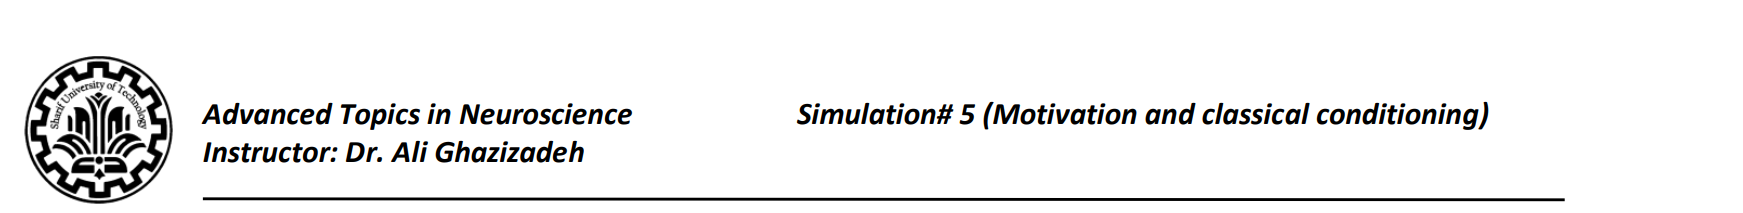

### [Arya Koureshi](https://aryakoureshi.github.io)
### 401204008
---

# PART I:

## Aim:
Modelling learning in classical conditioning paradigms

## Description:
We often need to rapidly learn about the value of new stimuli that we encounter or be ready for changes 
to familiar stimulus values that we were familiar without prior notice. Classical conditioning includes a 
large group of paradigms where different combination of reward histories with stimuli can form our 
judgement about their current values.
A well know model in classical conditioning and reinforcement learning is the Rescola-Wagner. This model
predicts that violations of our expected reward for each stimuli or combination of stimuli causes
incremental changes in our belief about their values.

## Instructions:
Use the model

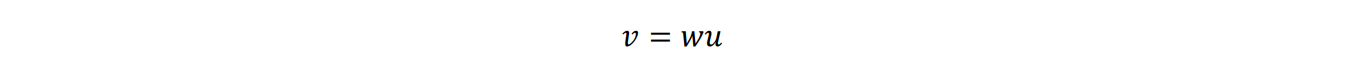

Where, 𝑤 is the weight, 𝑣 is the expected reward and 𝑢 is a binary variable that represents the presence 
or absence of the stimulus.
And update 𝑤 with the Rescola-Wagner (RW) rule:

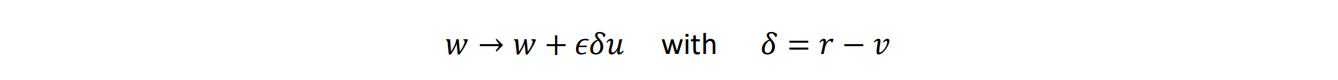

Where 𝜖 is the learning rate

Below are some of the well-known classical conditioning paradigms and the behavioral results of each 
paradigm as shown by experiments:

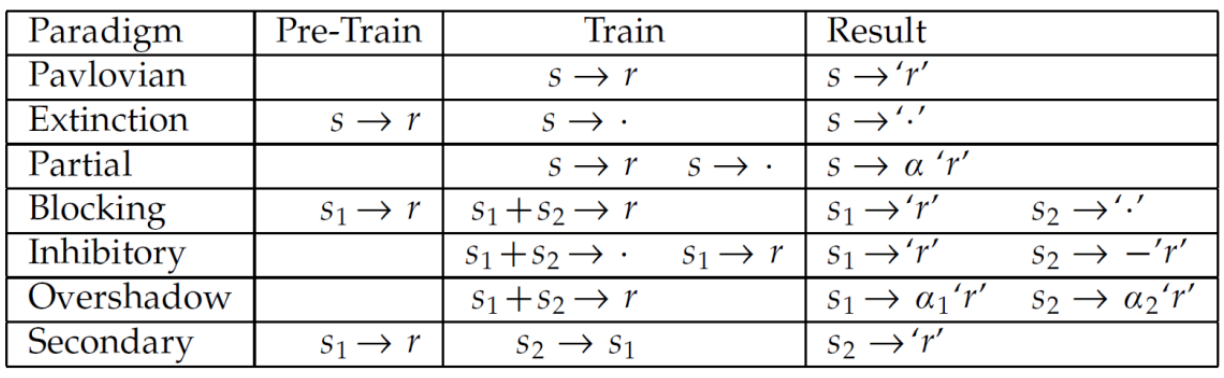

1) Using RW rule, simulate and plot the outcome of following paradigms: extinction, partial, blocking, inhibitory and overshadow. Assume a fixed learning rate and number trials in each phase to be such that learning almost saturates at the each of each phase. Which one the predictions of RW rule match the above table?

2) For overshadow condition, how can one have different amount of learned value for each stimuli? The ambiguity is a form of a concept known as ‘credit assignment’ in reinforcement learning literature

According to the paper, ‘Uncertainty and Learning’, implement Kalman filter method to explain blocking 
and unblocking in conditioning.

1) Simulate the results shown in figures 1-2 in the Dayan and Yu paper.

2) How does result change by changing process noise vs measurement noise?

3) What factors determine the value of Kalman gain at steady state? Can you derive an approximate relationship between steady state Kalman gain and the model parameters?

4) Does the change in uncertainty depend on the errors made in each trial or changes in the learning context?

5) Using this paradigm if we learn S1-> ‘r’. first and then S1->’-r’. how does learning the second context compares to the first context? What happens to the learning rate?

The uncertainty modeled by Kalman filter is referred to as ‘known uncertainty’. This is the uncertainty 
about the value of the stimulus for which the agent has some estimate. However there are times when 
we don’t even know how much we do not know about value of a stimulus. This is referred to as ‘ambiguity’ 
or ‘unknown uncertainty’. 

If we do not account for the ambiguity, then our estimate of uncertainty gets smaller over time and we 
cannot learn about new changes in the environment. To account for this Dayan and Yu made their model 
sensitive to the error magnitude. Large errors served to reset the uncertainty about the values to promote 
learning according to thresholding this value:

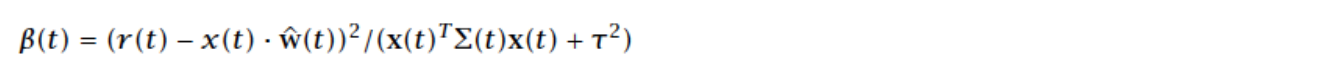

1) Simulate the results shown in Figure 3 of the paper.
---

In [1]:
# %% Imports
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [2]:
# %% Functions
def DeltaRule(w0, numTrials, e, u, r):
    weight = np.zeros((len(w0), numTrials))
    weight[:, 0] = w0
    for tr in range(1, numTrials):
        v = np.dot(weight[:, tr-1].T, u[:, tr-1])
        delta = r[:, tr-1] - v
        weight[:, tr] = weight[:, tr-1] + e * delta * u[:, tr-1]
    return weight

def KalmanFilter(u, r, cov, w, taw, noiseP, numTrials):
    weight = np.zeros((len(w), numTrials))
    weight[:, 0] = w
    covariance = np.zeros((2, 2, numTrials))
    covariance[:, :, 0] = cov
    for tr in range(1, numTrials):
        covariance_tmp = covariance[:, :, tr-1] + noiseP
        coeff = np.dot(covariance_tmp, u[:, tr-1]) / (np.dot(np.dot(np.reshape(u[:, tr-1], (2, 1)).T, covariance_tmp), u[:, tr-1]) + np.power(taw, 2))
        covariance[:, :, tr] = covariance_tmp - np.matmul(np.reshape(coeff, (2, 1)) * np.reshape(u[:, tr-1], (2, 1)).T, covariance_tmp)
        weight[:, tr] = weight[:, tr-1] + (coeff * (r[:, tr-1] - np.dot(weight[:, tr-1].T, u[:, tr-1])))
    return weight, covariance

def InhancedKalmanFilter(u, r, cov, w, taw, gamma, noiseP, noisePhi, numTrials):
    B = np.zeros((1, numTrials))
    weight = np.zeros((len(w), numTrials))
    weight[:, 0] = w
    covariance = np.zeros((len(w), len(w), numTrials))
    cov = np.eye(len(w)) * cov
    noiseP = np.eye(len(w)) * noiseP
    covariance[:, :, 0] = np.eye(len(w)) * cov
    for tr in range(1, numTrials):
        covariance_tmp = covariance[:, :, tr-1] + noiseP
        coeff = np.dot(covariance_tmp, u[:, tr-1]) / (np.dot(np.dot(u[:, tr-1].T, covariance_tmp), u[:, tr-1]) + np.power(taw, 2))
        covariance[:, :, tr] = covariance_tmp - np.matmul(coeff * u[:, tr-1].T, covariance_tmp)
        weight[:, tr] = weight[:, tr-1] + (coeff * (r[:, tr-1] - np.dot(weight[:, tr-1].T, u[:, tr-1])))
        B[:, tr] = np.power(r[:, tr] - np.dot(weight[:, tr].T, u[:, tr]), 2) /  (np.dot(np.dot(u[:, tr].T, covariance_tmp), u[:, tr]) + np.power(taw, 2))
        if B[:, tr] >= gamma:
            covariance[:, :, tr] = covariance[:, :, tr] + np.ones((len(w), 1)) * noisePhi
    return weight, covariance, B

---
## Part 1
### RW Rule
### Q1
#### Extinction

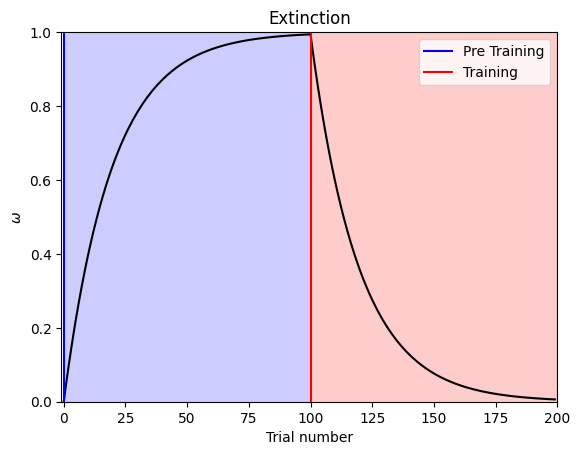

In [3]:
# %% Extinction
plt.figure()
numTrials = 200
e = 5e-2 #epsilon
u = np.ones((1, numTrials))
r = np.ones((1, numTrials))
r[0, int(numTrials/2):numTrials] = 0
w0 = [0]
weight = DeltaRule(w0, numTrials, e, u, r)
plt.plot(range(numTrials), weight[0], 'k')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')
plt.title("Extinction")
plt.xlim([-1, numTrials])
plt.ylim([0, 1])
plt.gca().add_patch(Rectangle((0, 0), 100, 1 , facecolor='b', alpha=0.2))
plt.axvline(x=0, color='b', linestyle='-', label='Pre Training')
plt.gca().add_patch(Rectangle((100, 0), 100, 1 , facecolor='r', alpha=0.2))
plt.axvline(x=100, color='r', linestyle='-', label='Training')
plt.legend()
plt.show()

The extinction paradigm follows a plot that bears resemblance to the one presented in the course slides, where it starts with an increase and subsequently decreases once the stimuli cease to exist.

---

#### Partial

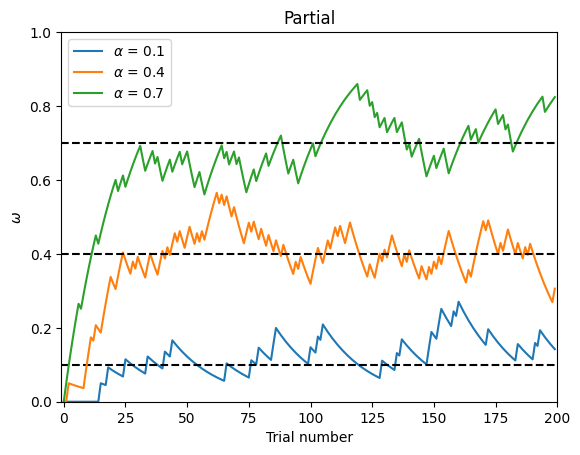

In [4]:
# %% Partial
plt.figure()
numTrials = 200
e = 5e-2 #epsilon
Alpha = [0.1, 0.4, 0.7]
for alpha in Alpha:
    u = np.ones((1, numTrials))
    r_tmp = np.random.rand(numTrials) < alpha
    r = np.array([float(b) for b in r_tmp])
    r = np.reshape(r, (1, len(r)))
    w0 = [0]
    weight = DeltaRule(w0, numTrials, e, u, r)
    plt.plot(range(numTrials), weight[0], label=r'$\alpha$ = '+str(alpha))
    plt.axhline(y=alpha, color='k', linestyle='--')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')
plt.title("Partial")
plt.xlim([-1, numTrials])
plt.ylim([0, 1])
plt.legend()
plt.show()

The partial paradigm bears a resemblance to the plot depicted in the course slides, whereby it exhibits a rise and subsequently decreases when there is no stimulus.

---

#### Blocking

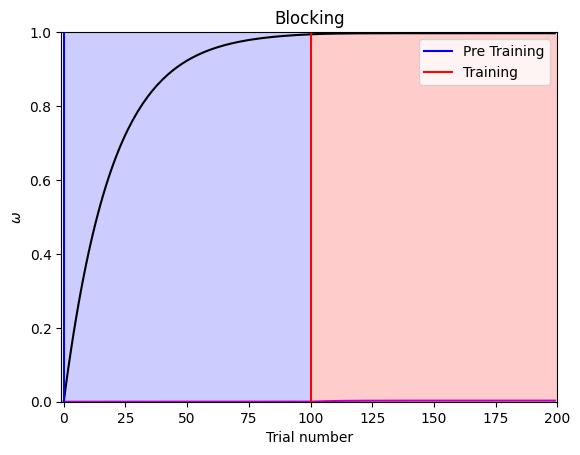

In [5]:
# %% Blocking
plt.figure()
numTrials = 200
e = 5e-2 #epsilon
u = np.ones((2, numTrials))
r = np.ones((1, numTrials))
u[1, :int(numTrials/2)] = 0
w0 = [0, 0]
weight = DeltaRule(w0, numTrials, e, u, r)
plt.plot(range(numTrials), weight[0], 'k')
plt.plot(range(numTrials), weight[1], 'm')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')
plt.title("Blocking")
plt.xlim([-1, numTrials])
plt.ylim([0, 1])
plt.gca().add_patch(Rectangle((0, 0), 100, 1 , facecolor='b', alpha=0.2))
plt.axvline(x=0, color='b', linestyle='-', label='Pre Training')
plt.gca().add_patch(Rectangle((100, 0), 100, 1 , facecolor='r', alpha=0.2))
plt.axvline(x=100, color='r', linestyle='-', label='Training')
plt.legend()
plt.show()

As with the outcomes presented in the question set table, w1 attains a value of 1 and w2 exhibits minimal deviation from 0, although there is a slight increment observed in w2 during the training trials.

---

#### Inhibitory

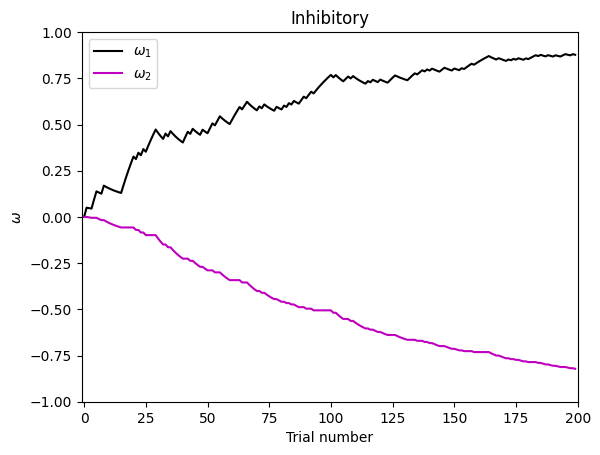

In [6]:
# %% Inhibitory
plt.figure()
numTrials = 200
e = 5e-2 #epsilon
u = np.ones((2, numTrials))
u[1, :] = np.random.rand(numTrials) < 0.5
r = np.zeros((1, numTrials))
for i in range(len(u[0])):
    if u[0, i] + u[1, i] != 2 and u[0, i] == 1:
        r[0, i] = 1
w0 = [0, 0]
weight = DeltaRule(w0, numTrials, e, u, r)
plt.plot(range(numTrials), weight[0], 'k', label=r'$\omega_1$')
plt.plot(range(numTrials), weight[1], 'm', label=r'$\omega_2$')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')
plt.title("Inhibitory")
plt.xlim([-1, numTrials])
plt.ylim([-1, 1])
plt.legend()
plt.show()

The results in the figure align with those in the question set table, and as anticipated, w1 converges to 1 and w2 to -1 throughout the trials.

---

#### Overshadow

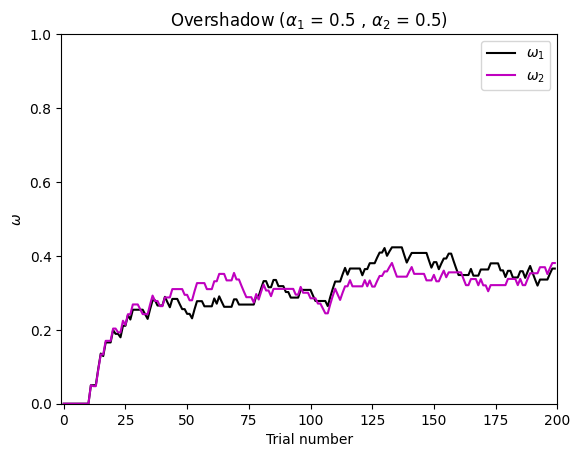

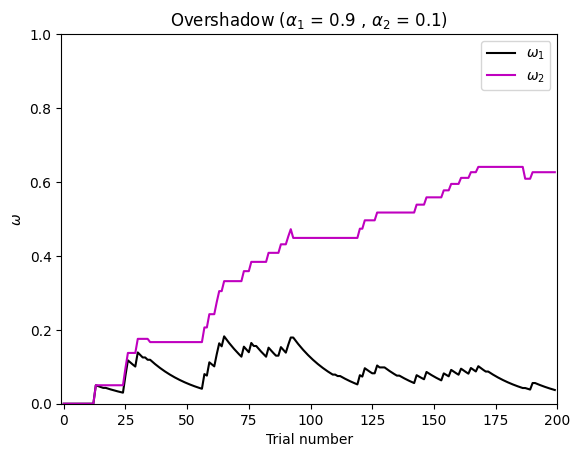

In [7]:
# %% Overshadow
plt.figure()
numTrials = 200
e = 5e-2 #epsilon
alpha1 = 0.5
alpha2 = 0.5
u = np.zeros((2, numTrials))
u[0, :] = np.random.rand(numTrials) < alpha1
u[1, :] = np.random.rand(numTrials) < alpha2
r = np.zeros((1, numTrials))
for i in range(len(u[0])):
    if u[0, i] + u[1, i] == 2:
        r[0, i] = 1
w0 = [0, 0]
weight = DeltaRule(w0, numTrials, e, u, r)
plt.plot(range(numTrials), weight[0], 'k', label=r'$\omega_1$')
plt.plot(range(numTrials), weight[1], 'm', label=r'$\omega_2$')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')
plt.title(r"Overshadow ($\alpha_1$ = 0.5 , $\alpha_2$ = 0.5)")
plt.xlim([-1, numTrials])
plt.ylim([0, 1])
plt.legend()
plt.show()

plt.figure()
numTrials = 200
e = 5e-2 #epsilon
alpha1 = 0.9
alpha2 = 0.1
u = np.zeros((2, numTrials))
u[0, :] = np.random.rand(numTrials) < alpha1
u[1, :] = np.random.rand(numTrials) < alpha2
r = np.zeros((1, numTrials))
for i in range(len(u[0])):
    if u[0, i] + u[1, i] == 2:
        r[0, i] = 1
w0 = [0, 0]
weight = DeltaRule(w0, numTrials, e, u, r)
plt.plot(range(numTrials), weight[0], 'k', label=r'$\omega_1$')
plt.plot(range(numTrials), weight[1], 'm', label=r'$\omega_2$')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')
plt.title(r"Overshadow ($\alpha_1$ = 0.9 , $\alpha_2$ = 0.1)")
plt.xlim([-1, numTrials])
plt.ylim([0, 1])
plt.legend()
plt.show()

### Q2
In the overshadowing paradigm, stimuli usually acquire different weights due to one of them being more salient than the other. Consequently, even though the reward is presented in a small number of trials, the stimulus with a higher probability may have a lower weight.

---
## Part 2
### Kalman filter
### Q1
#### Drift

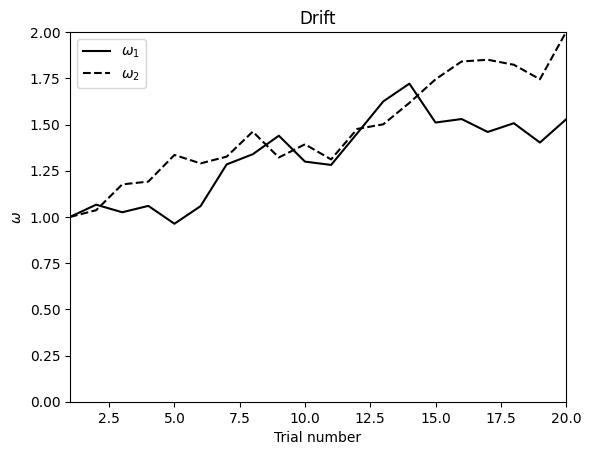

In [8]:
# %% Drift
plt.figure()
numTrials = 20
taw = 0.1
v = np.vstack((np.random.normal(0, taw, numTrials), np.random.normal(0, 0.1, numTrials)))
w0 = [1, 1]
weight = np.zeros((len(w0), numTrials))
weight[0, 0] = w0[0]
weight[1, 0] = w0[1]
for tr in range(1, numTrials):
    weight[:, tr] = weight[:, tr-1] - v[:, tr-1]

plt.plot(range(1, numTrials + 1), weight[0, :], 'k', label = r'$\omega_1$')
plt.plot(range(1, numTrials + 1), weight[1, :], '--k', label = r'$\omega_2$')
plt.title('Drift')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')
plt.xlim([1, numTrials])
plt.ylim([0, 2])
plt.legend()
plt.show()

#### Blocking

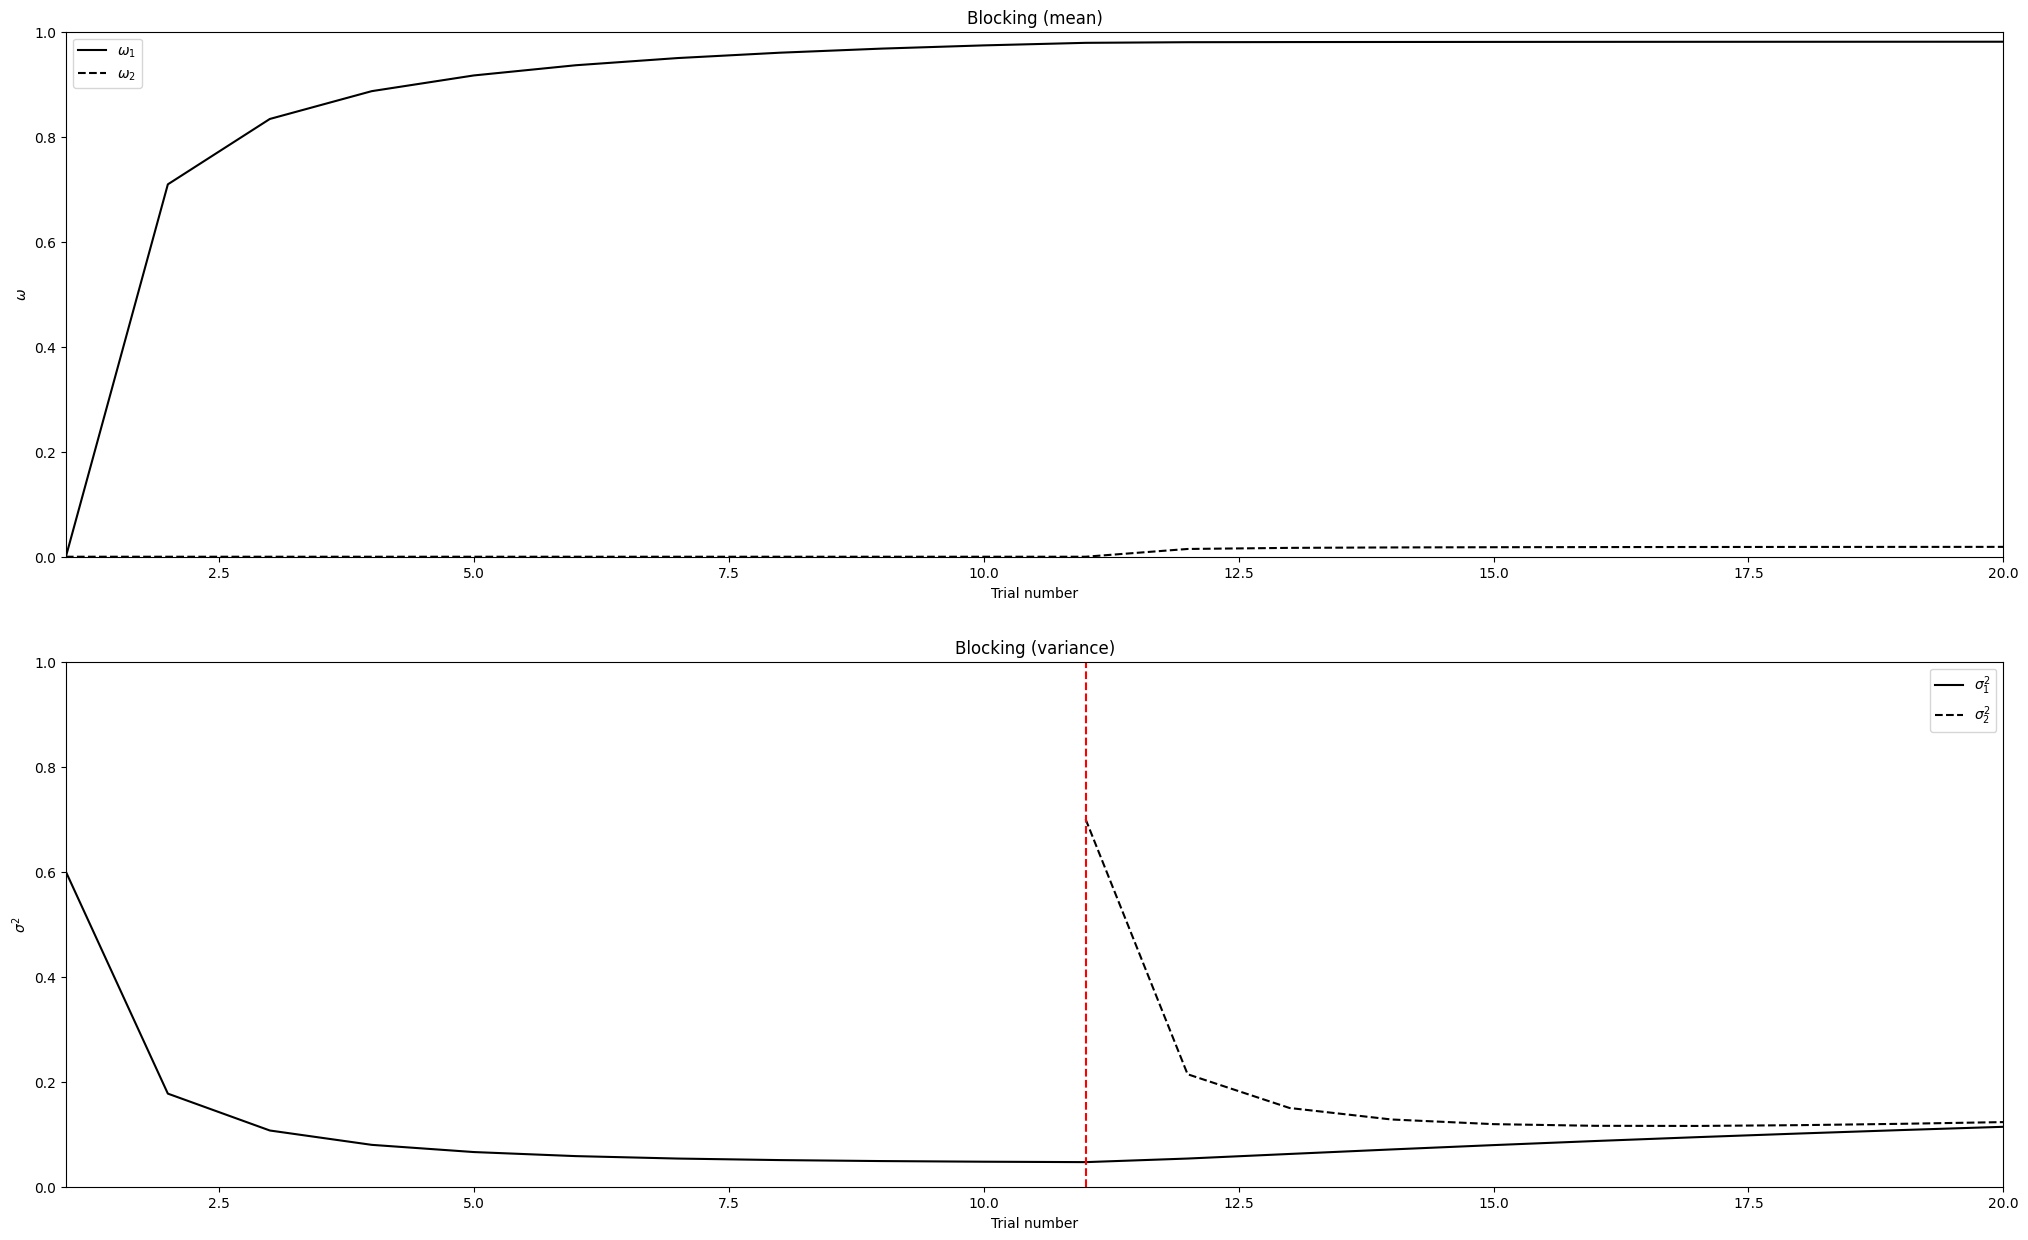

In [9]:
# %% Blocking
numTrials = 20
taw = 0.5
u = np.ones((2, numTrials))
r = np.ones((1, numTrials))
u[1, :int(numTrials/2)] = 0
w0 = [0, 0]
cov = np.eye(2) * 0.6
noiseP = np.eye(2) * 0.01
[weight, covariance] = KalmanFilter(u, r, cov, w0, taw, noiseP, numTrials)

fig, ax = plt.subplots(2, 1, figsize=(25, 15))

ax[0].plot(range(1, numTrials + 1), weight[0, :], 'k', label = r'$\omega_1$')
ax[0].plot(range(1, numTrials + 1), weight[1, :], '--k', label = r'$\omega_2$')
ax[0].set_title('Blocking (mean)')
ax[0].set_xlabel("Trial number")
ax[0].set_ylabel(r'$\omega$')
ax[0].set_xlim([1, numTrials])
ax[0].set_ylim([0, 1])
ax[0].legend()

ax[1].plot(range(1, numTrials + 1), np.squeeze(covariance[0, 0, :]), 'k', label = r'$\sigma_1^2$')
ax[1].plot(range(int(numTrials/2) + 1, numTrials + 1), np.squeeze(covariance[1, 1, int(numTrials/2):]), '--k', label = r'$\sigma_2^2$')
ax[1].axvline(x=int(numTrials/2) + 1, linestyle='--', color='r')
ax[1].set_title('Blocking (variance)')
ax[1].set_xlabel("Trial number")
ax[1].set_ylabel(r'$\sigma^2$')
ax[1].set_xlim([1, numTrials])
ax[1].set_ylim([0, 1])
ax[1].legend();

#### Unblocking

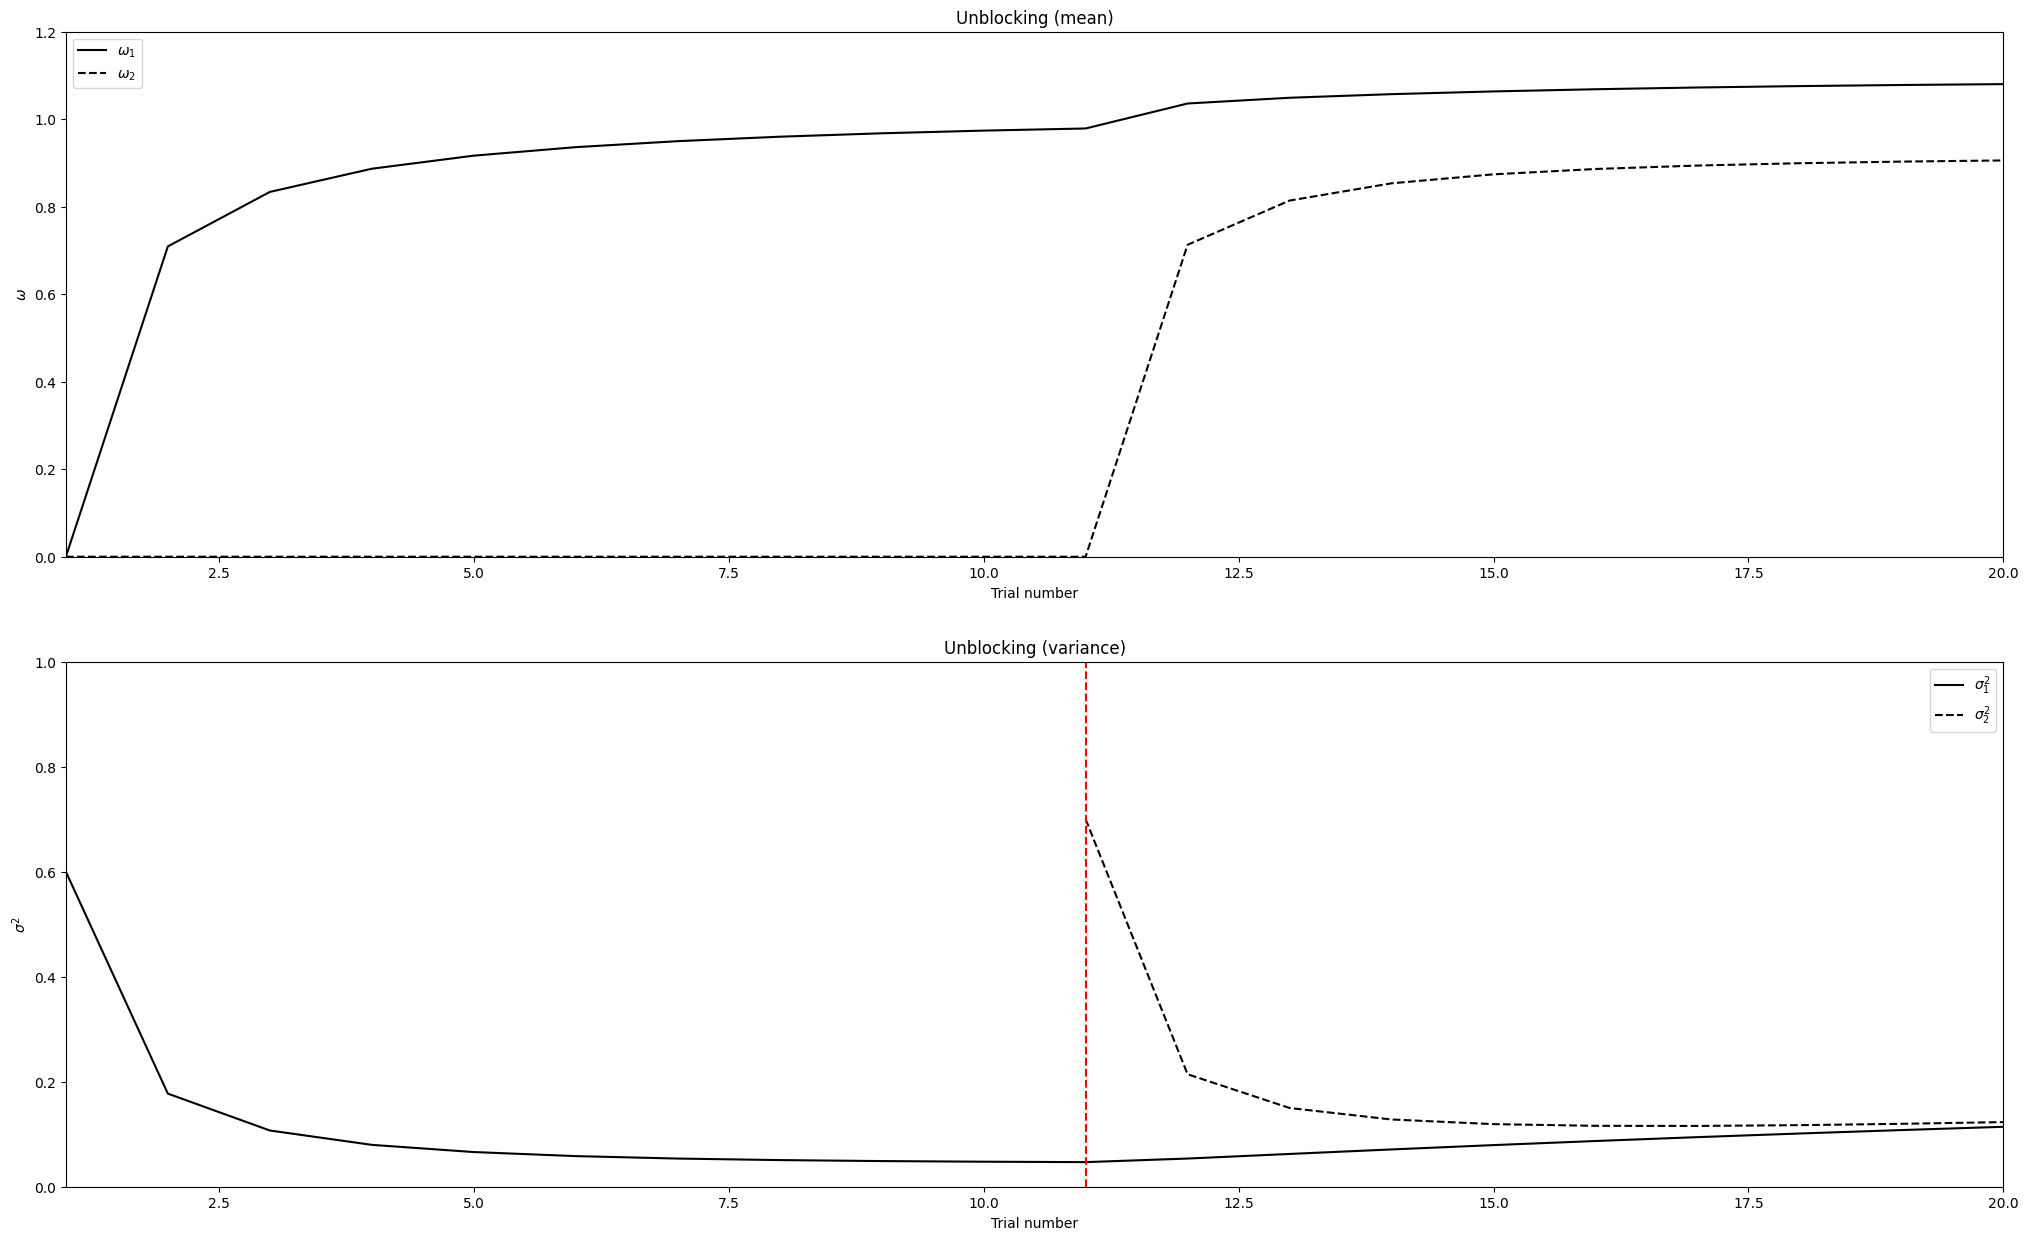

In [10]:
numTrials = 20
taw = 0.5
u = np.ones((2, numTrials))
r = np.ones((1, numTrials))
u[1, :int(numTrials/2)] = 0
r[0, int(numTrials/2):] = 2
w0 = [0, 0]
cov = np.eye(2) * 0.6
noiseP = np.eye(2) * 0.01
[weight, covariance] = KalmanFilter(u, r, cov, w0, taw, noiseP, numTrials)

fig, ax = plt.subplots(2, 1, figsize=(25, 15))

ax[0].plot(range(1, numTrials + 1), weight[0, :], 'k', label = r'$\omega_1$')
ax[0].plot(range(1, numTrials + 1), weight[1, :], '--k', label = r'$\omega_2$')
ax[0].set_title('Unblocking (mean)')
ax[0].set_xlabel("Trial number")
ax[0].set_ylabel(r'$\omega$')
ax[0].set_xlim([1, numTrials])
ax[0].set_ylim([0, 1.2])
ax[0].legend()

ax[1].plot(range(1, numTrials + 1), np.squeeze(covariance[0, 0, :]), 'k', label = r'$\sigma_1^2$')
ax[1].plot(range(int(numTrials/2) + 1, numTrials + 1), np.squeeze(covariance[1, 1, int(numTrials/2):]), '--k', label = r'$\sigma_2^2$')
ax[1].axvline(x=int(numTrials/2) + 1, linestyle='--', color='r')
ax[1].set_title('Unblocking (variance)')
ax[1].set_xlabel("Trial number")
ax[1].set_ylabel(r'$\sigma^2$')
ax[1].set_xlim([1, numTrials])
ax[1].set_ylim([0, 1])
ax[1].legend();

The figures' parameters are derived from the paper or are configured to closely resemble the paper's figures.

Parameters of Kalman filter:
* Process noise = 0.01
* $\tau$ = 0.5
* $\omega_0$ = 0
* $\sum{t_0}$ = 0.06

---

#### Backward Blocking

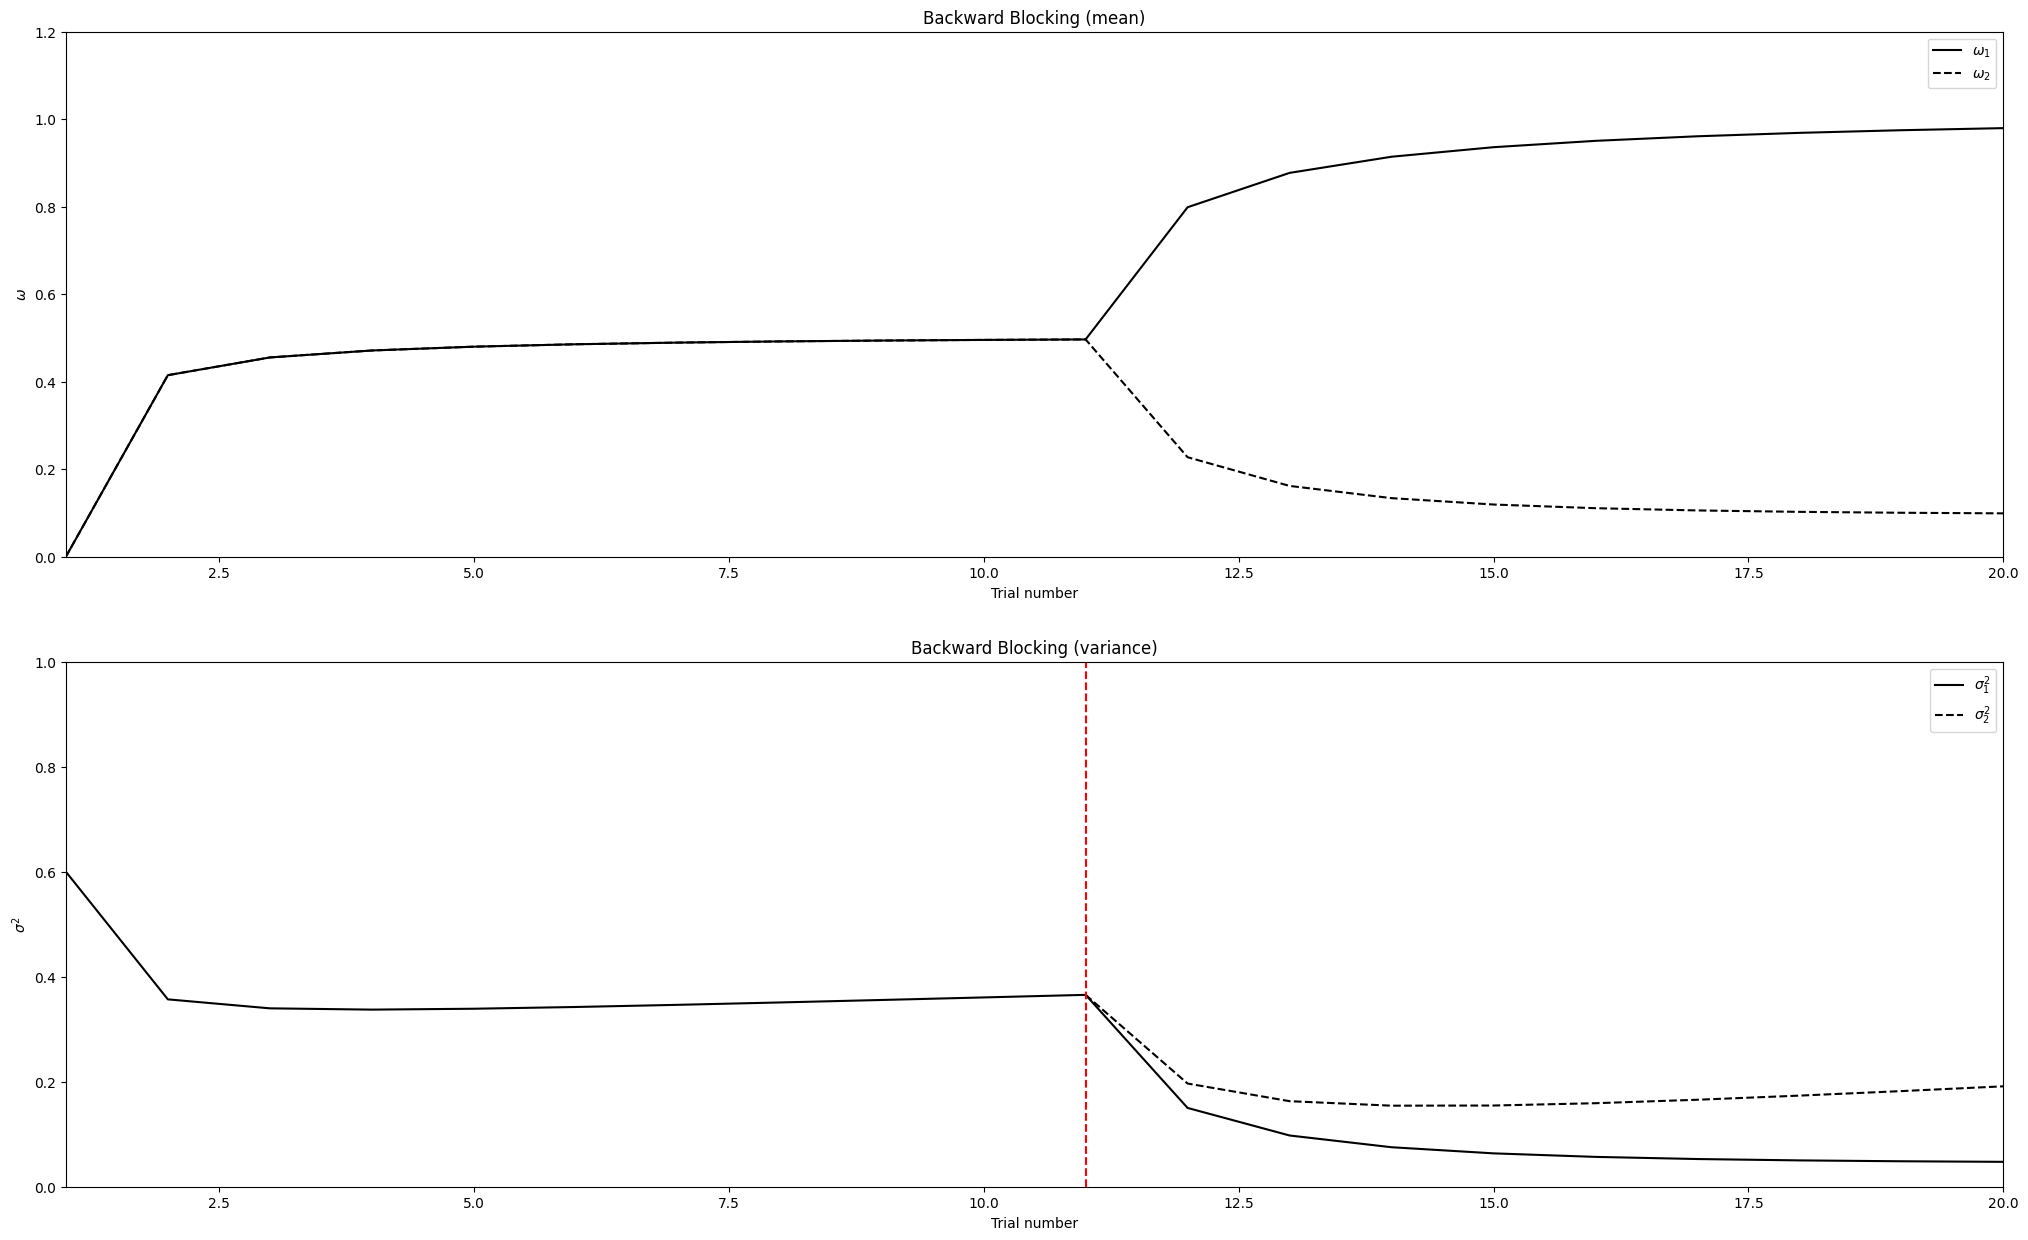

In [11]:
# %% Backward Blocking
numTrials = 20
taw = 0.5
u = np.ones((2, numTrials))
r = np.ones((1, numTrials))
u[1, int(numTrials/2):] = 0
w0 = [0, 0]
cov = np.eye(2) * 0.6
noiseP = np.eye(2) * 0.01
[weight, covariance] = KalmanFilter(u, r, cov, w0, taw, noiseP, numTrials)

fig, ax = plt.subplots(2, 1, figsize=(25, 15))

ax[0].plot(range(1, numTrials + 1), weight[0, :], 'k', label = r'$\omega_1$')
ax[0].plot(range(1, numTrials + 1), weight[1, :], '--k', label = r'$\omega_2$')
ax[0].set_title('Backward Blocking (mean)')
ax[0].set_xlabel("Trial number")
ax[0].set_ylabel(r'$\omega$')
ax[0].set_xlim([1, numTrials])
ax[0].set_ylim([0, 1.2])
ax[0].legend()

ax[1].plot(range(1, numTrials + 1), np.squeeze(covariance[0, 0, :]), 'k', label = r'$\sigma_1^2$')
ax[1].plot(range(int(numTrials/2) + 1, numTrials + 1), np.squeeze(covariance[1, 1, int(numTrials/2):]), '--k', label = r'$\sigma_2^2$')
ax[1].axvline(x=int(numTrials/2) + 1, linestyle='--', color='r')
ax[1].set_title('Backward Blocking (variance)')
ax[1].set_xlabel("Trial number")
ax[1].set_ylabel(r'$\sigma^2$')
ax[1].set_xlim([1, numTrials])
ax[1].set_ylim([0, 1])
ax[1].legend();

#### Contour Plots

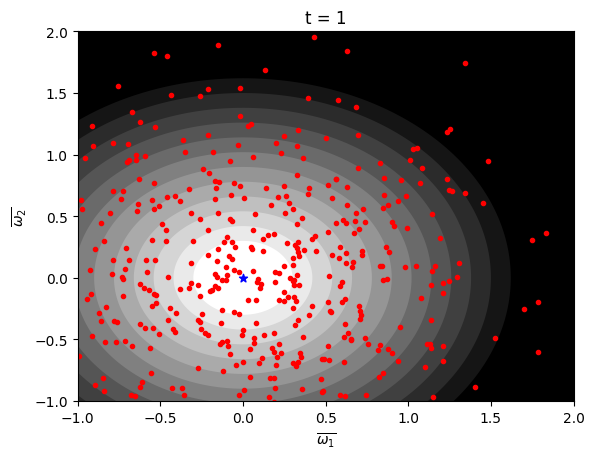

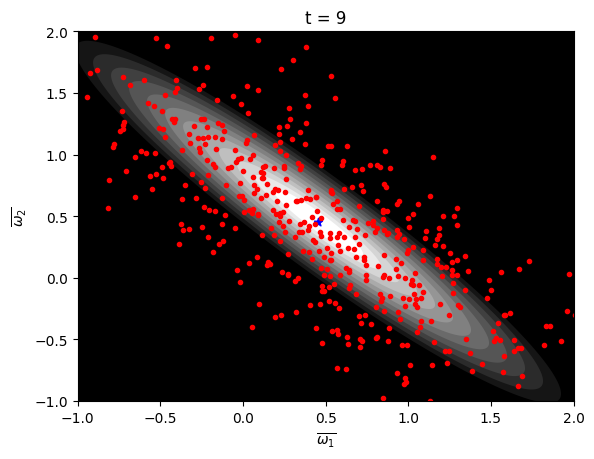

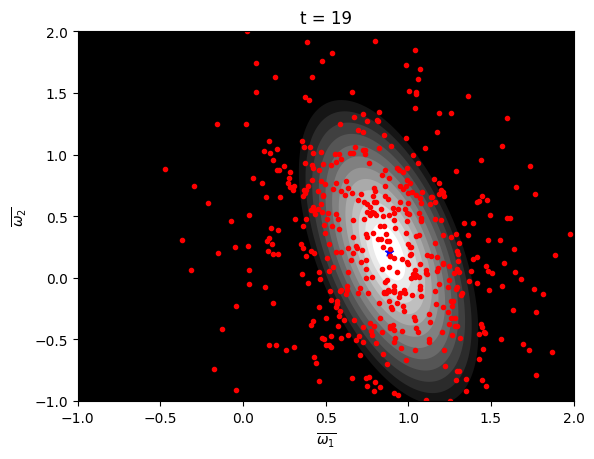

In [12]:
# %% Contour Plots
numTrials = 20
taw = 1.2
u = np.ones((2, numTrials))
r = np.ones((1, numTrials))
u[1, int(numTrials/2):] = 0
w0 = [0, 0]
cov = np.eye(2) * 0.6
noiseP = np.eye(2) * 0.02
[weight, covariance] = KalmanFilter(u, r, cov, w0, taw, noiseP, numTrials)

r_list = np.arange(0.5, 3, 0.2)
theta = np.arange(0, 2*np.pi, 0.01)
colors = np.linspace(1, 0, len(r_list))
i = 0

for t in [0, 8, 18]:
    plt.figure()
    plt.gca().add_patch(Rectangle((-1, -1), 3, 3 , facecolor='k', alpha=1))
    covarianceC = covariance[:, :, t]
    weightC = weight[:, t]
    j = len(r_list)-1
    for r in r_list[::-1]:
        x = np.sin(theta) * r
        y = np.cos(theta) * r
        tmp = np.matmul(covarianceC, np.vstack((x, y)))        
        x = weightC[0] + tmp[0, :]
        y = weightC[1] + tmp[1, :]
        fill_color = np.array([1, 1, 1]) * colors[j]
        plt.fill(x, y, facecolor=fill_color, edgecolor='none')
        j = j - 1
    plt.scatter(weightC[0], weightC[1], c='b', marker='*')
    generatedData = np.random.multivariate_normal(weightC, covarianceC, size=500)
    plt.scatter(generatedData[:, 0], generatedData[:, 1], c='r', marker='.')
    plt.xlabel(r'$\overline {\omega_1}$')
    plt.ylabel(r'$\overline {\omega_2}$')
    plt.title('t = {}'.format(t+1))
    i += 1
    plt.xlim([-1, 2])
    plt.ylim([-1, 2])

### Q2

#### Effect of process noise and measurement noise

C:\Users\aryak\AppData\Local\Temp\ipykernel_49132\2993963743.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(2, 1, figsize=(25, 15))


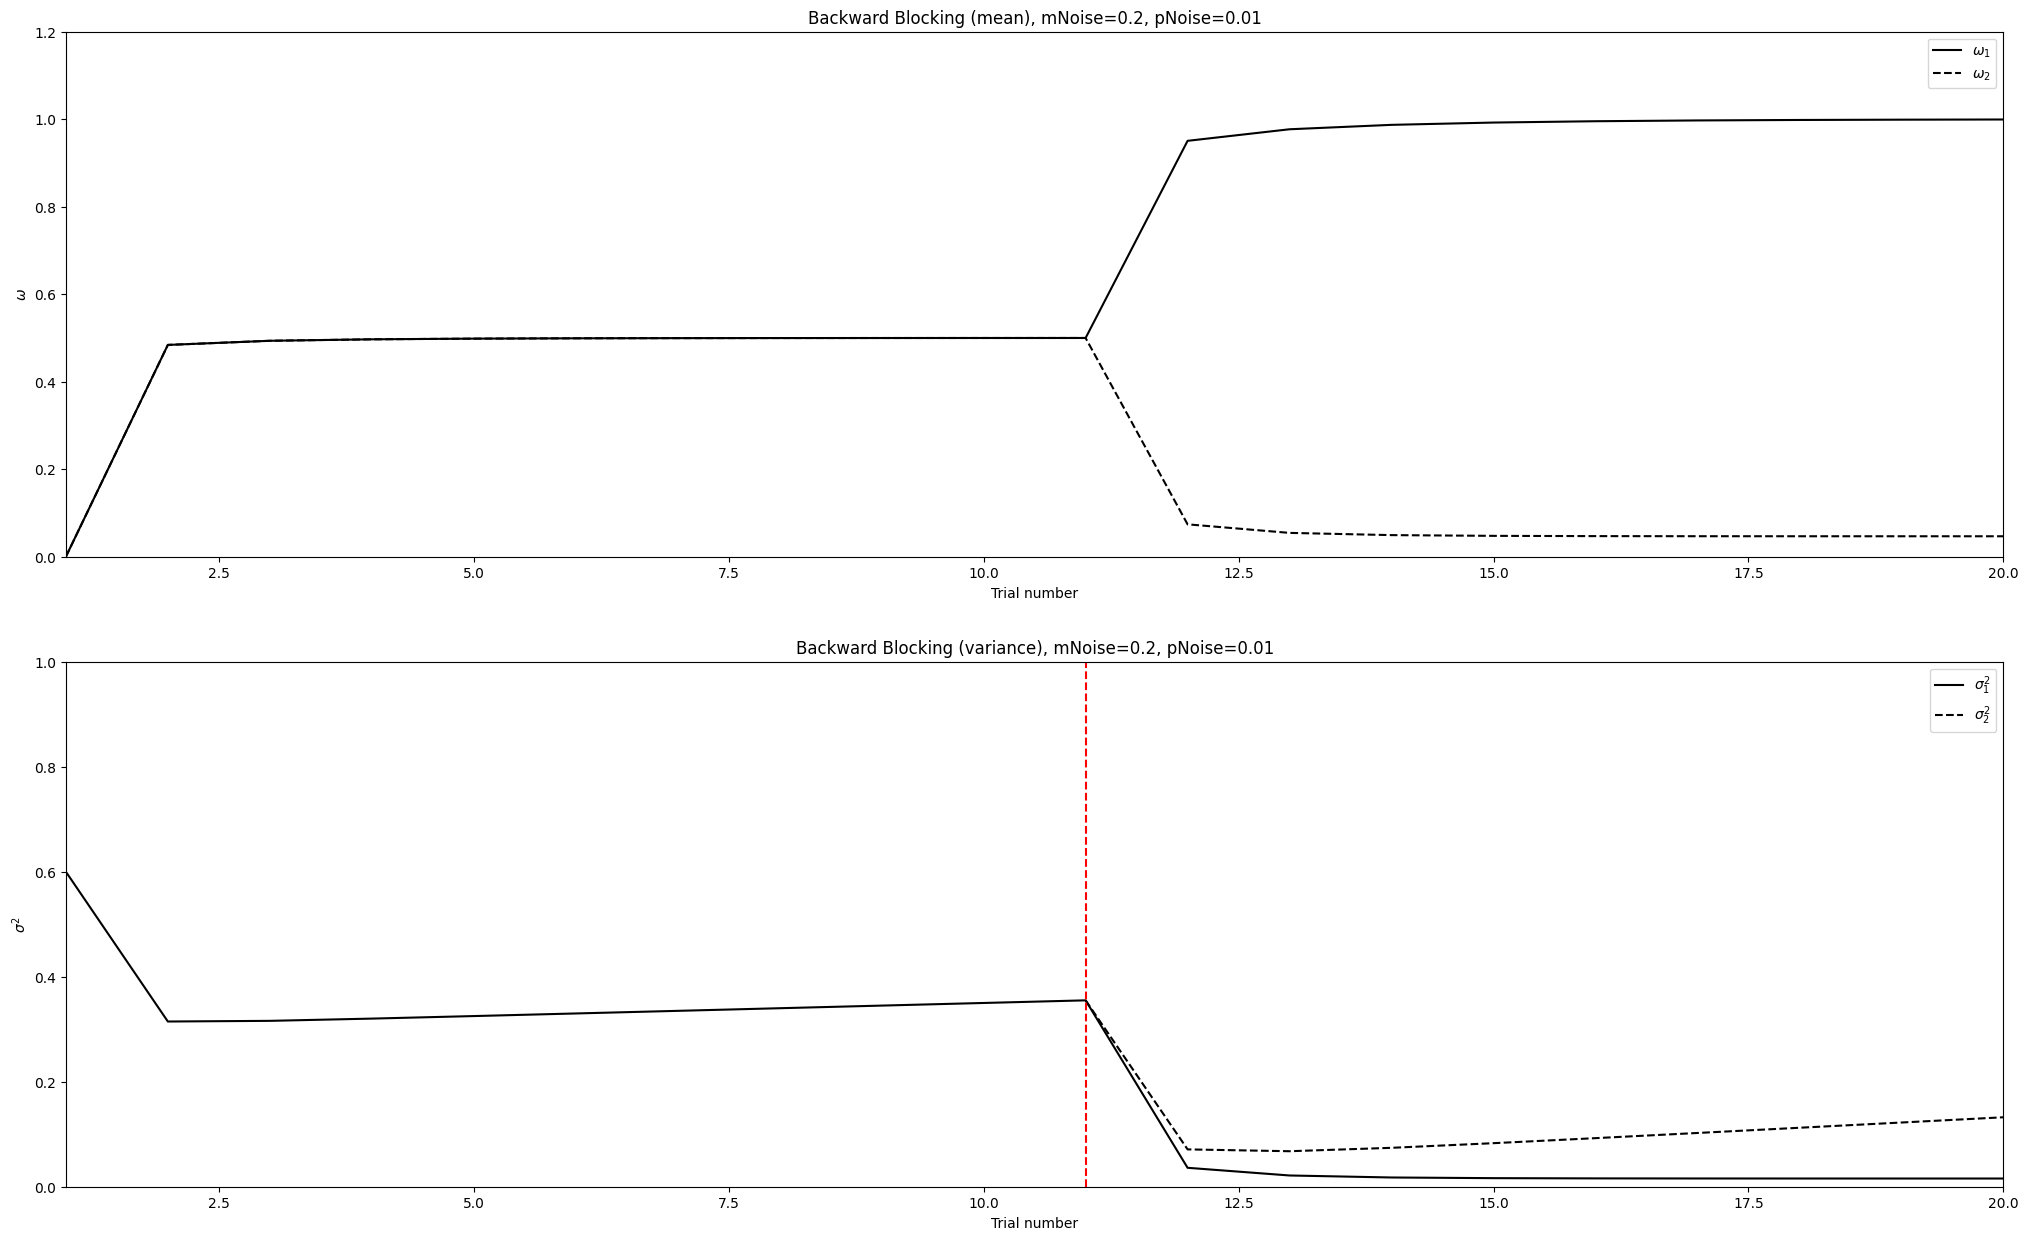

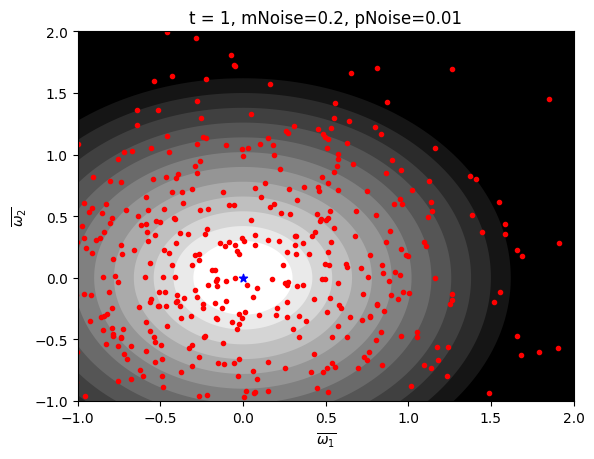

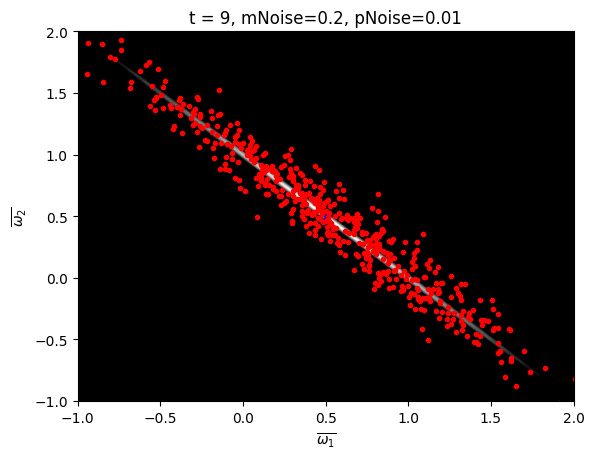

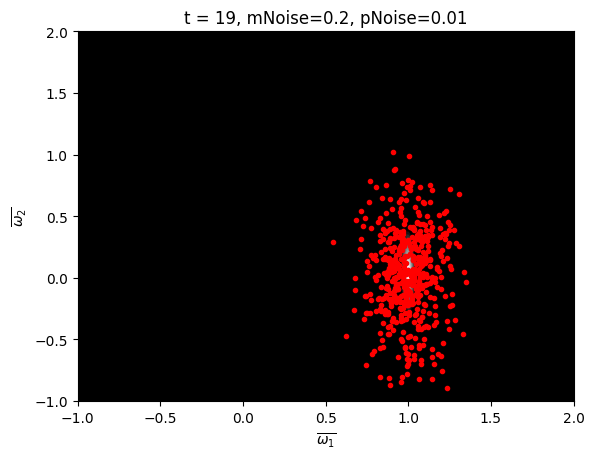

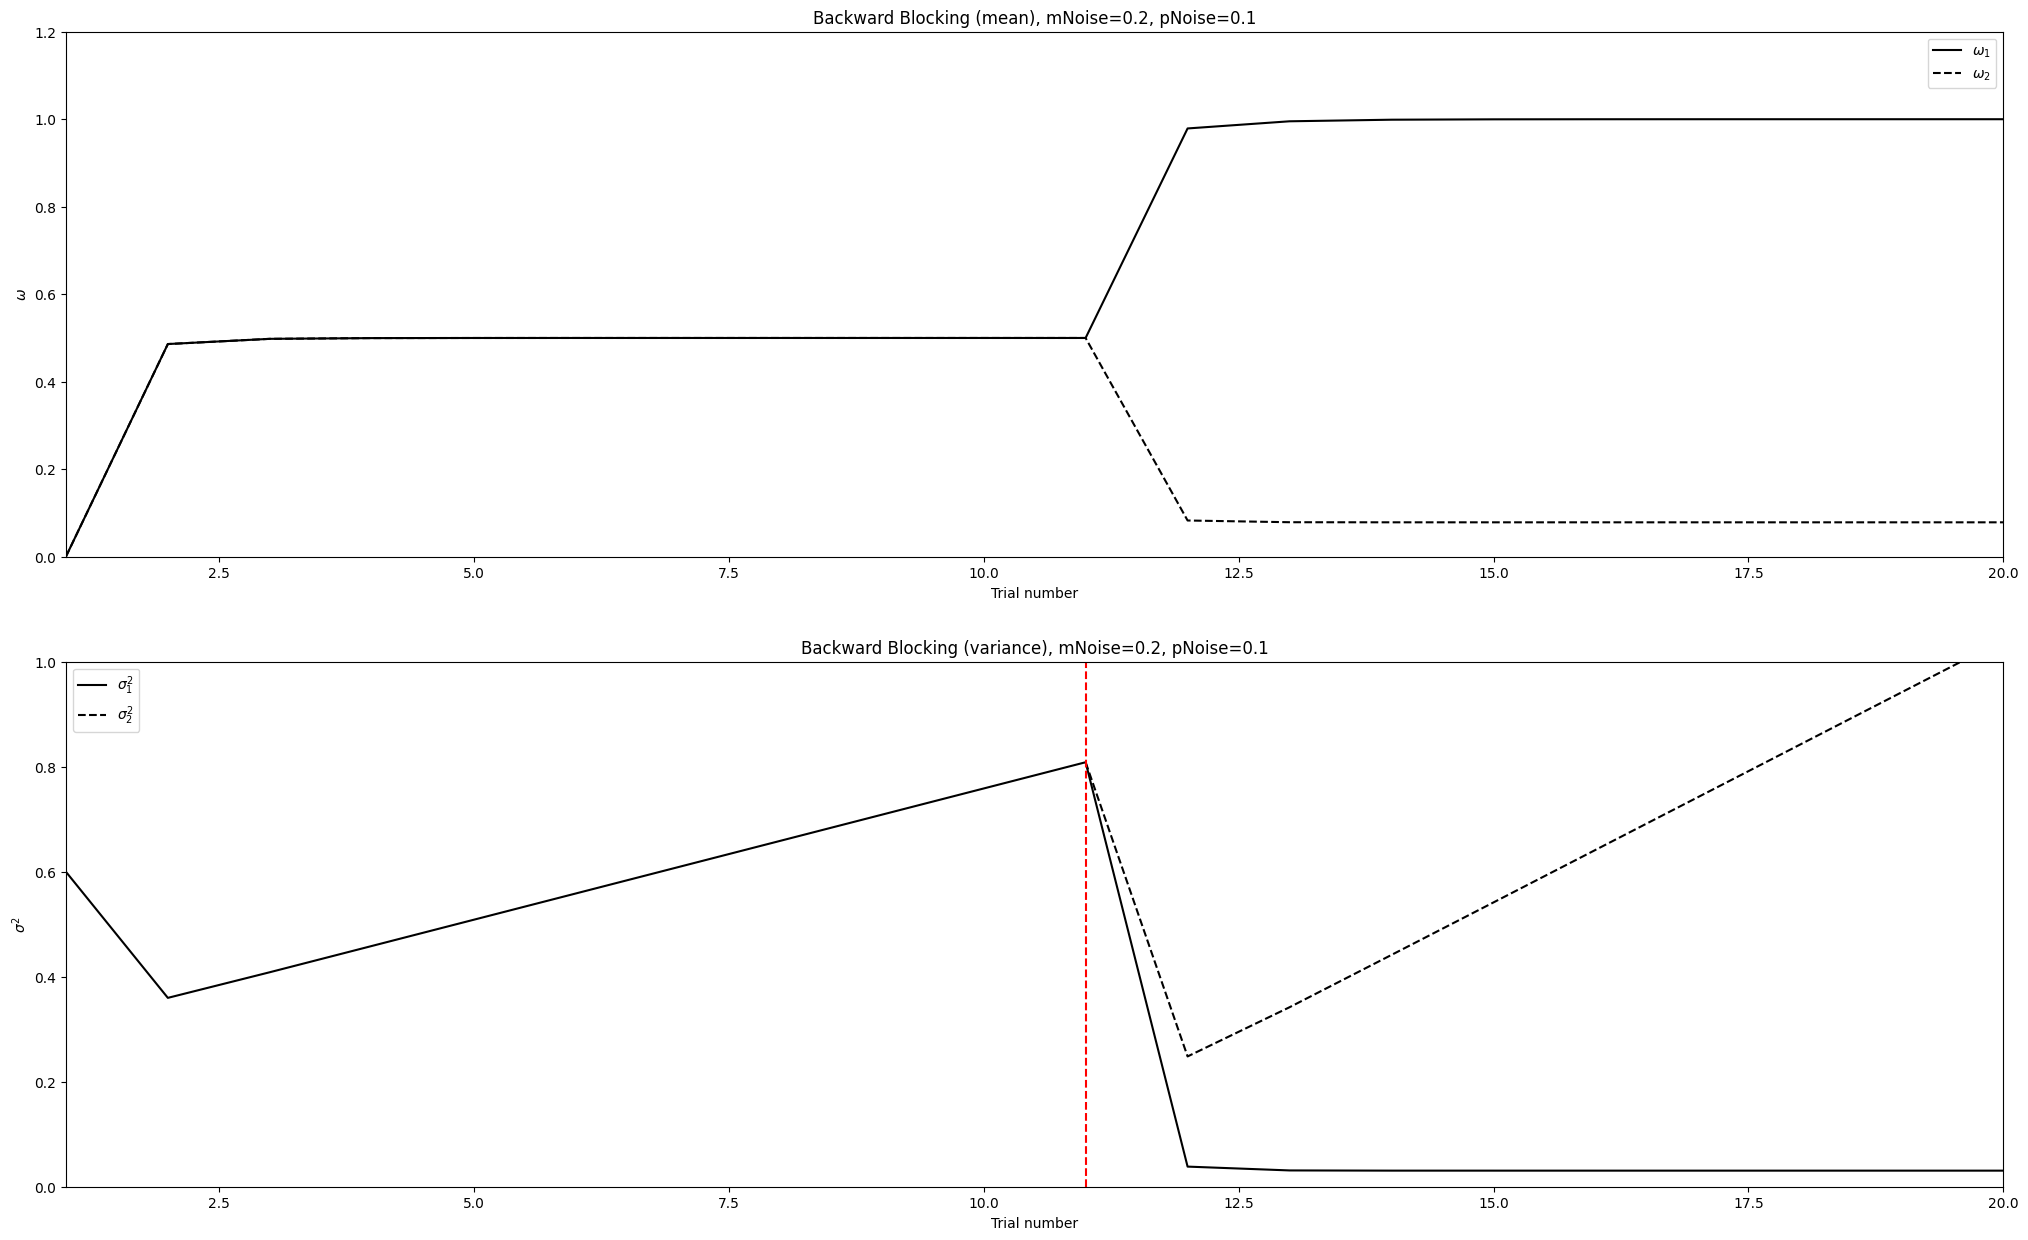

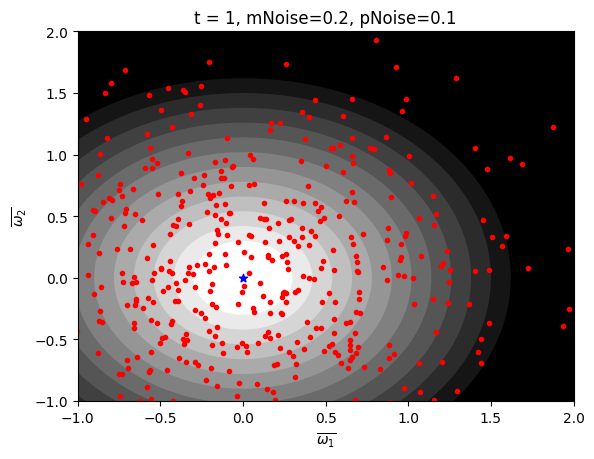

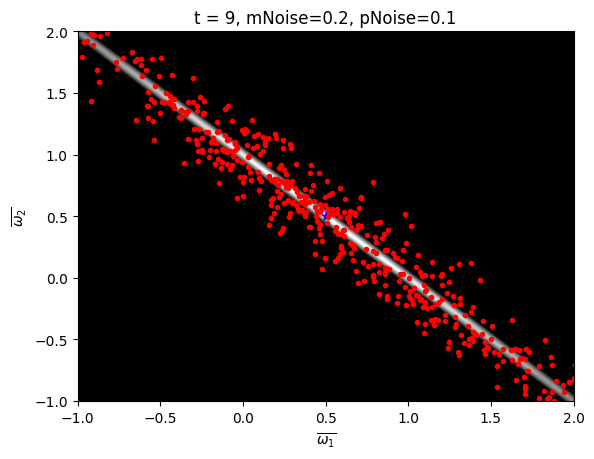

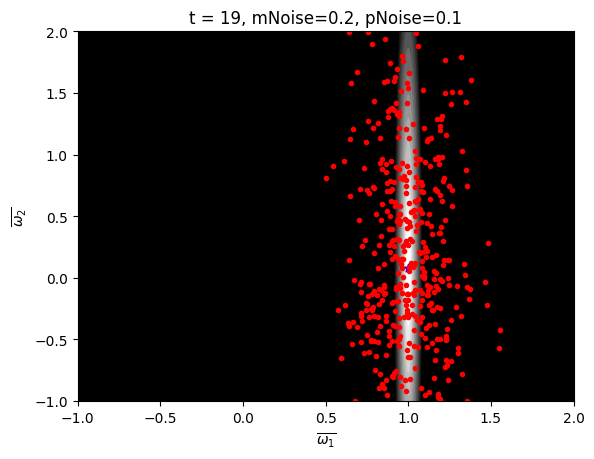

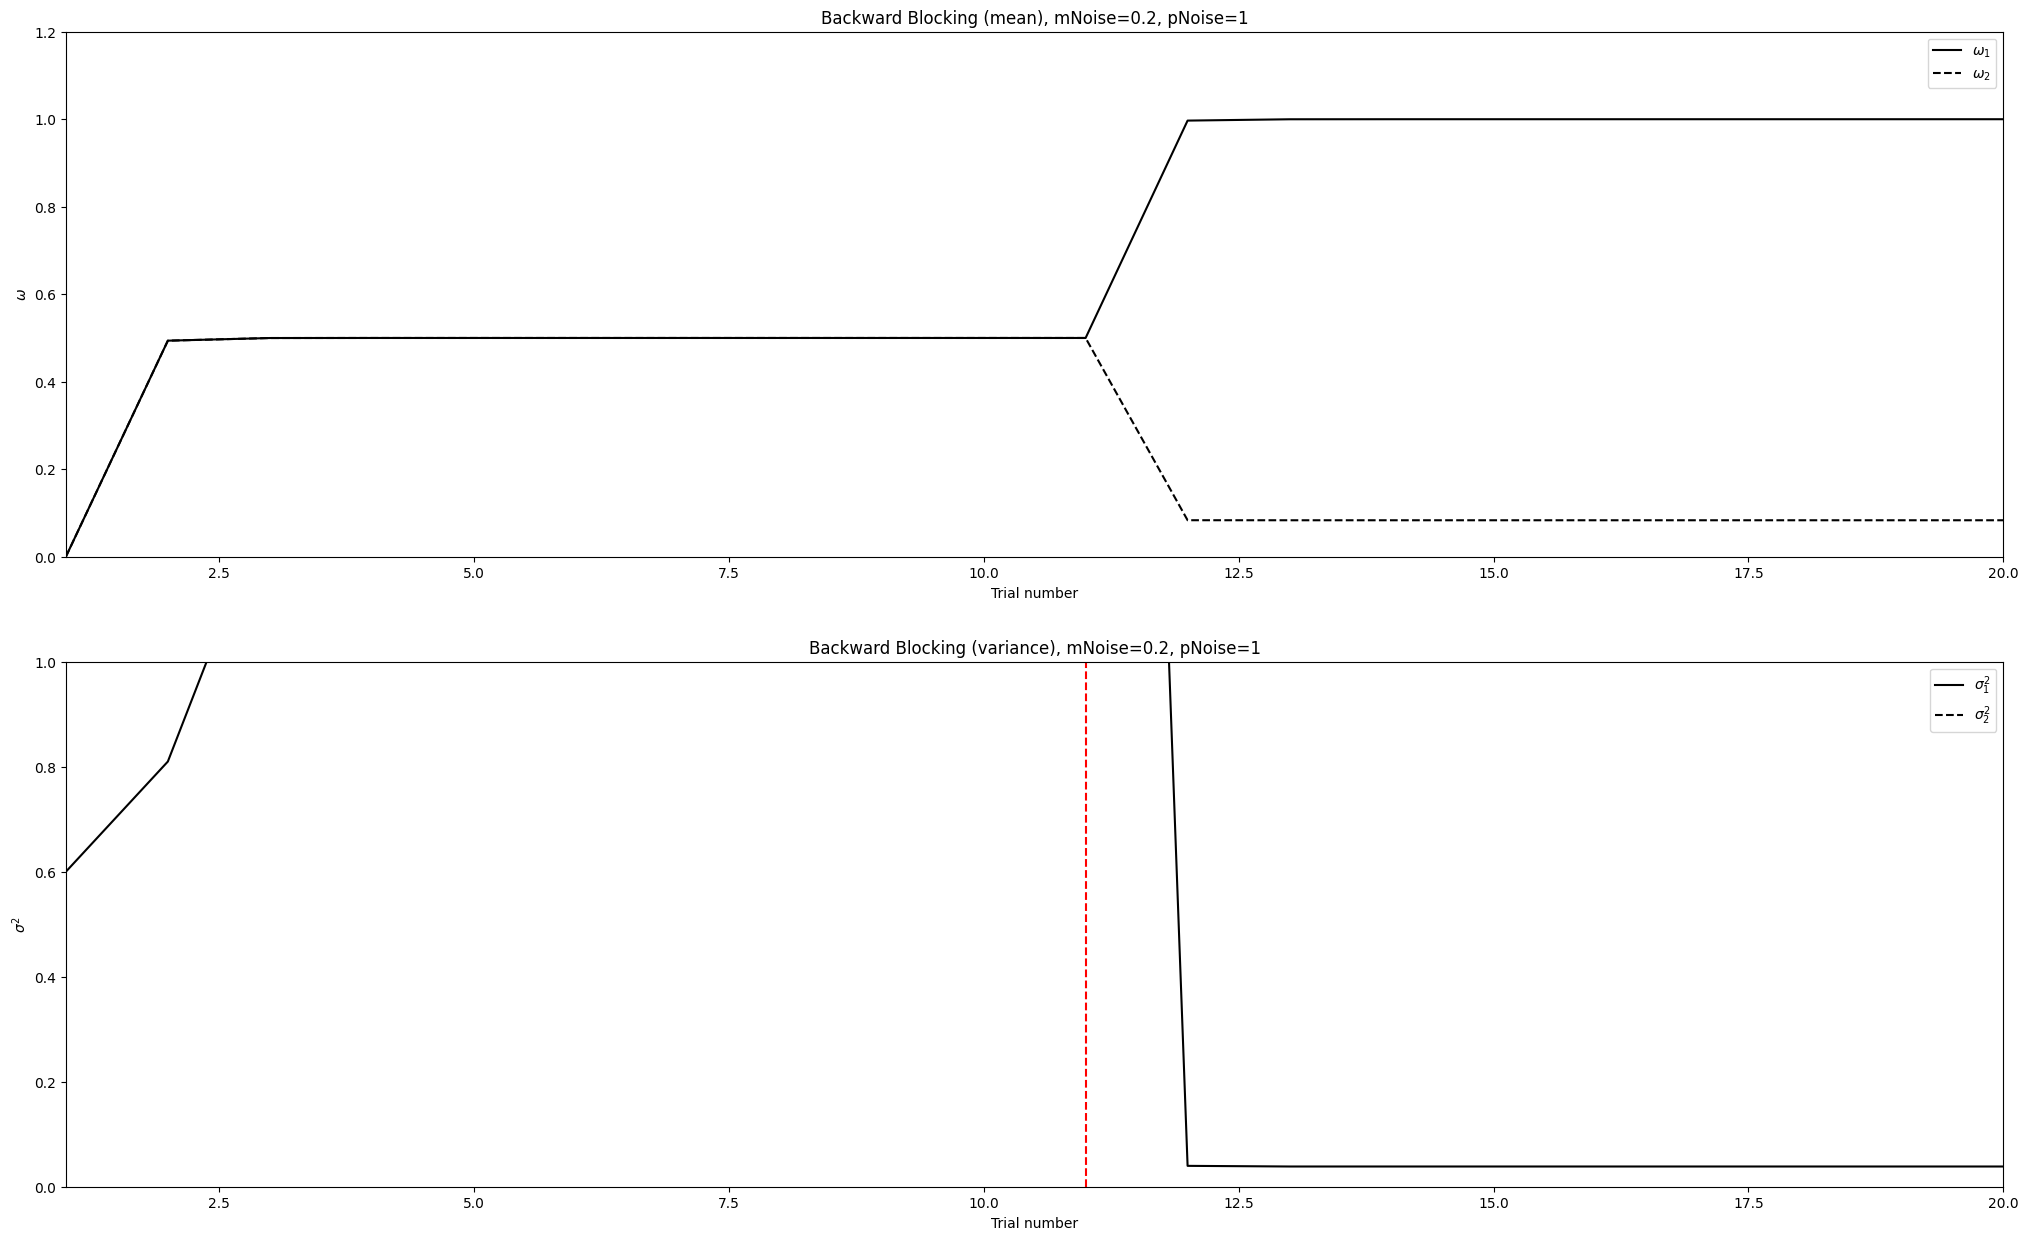

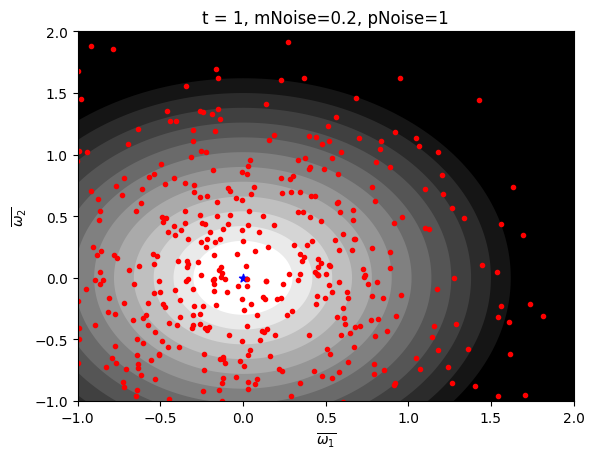

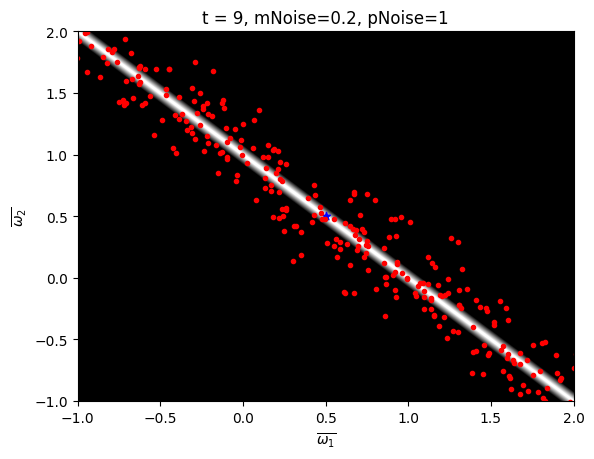

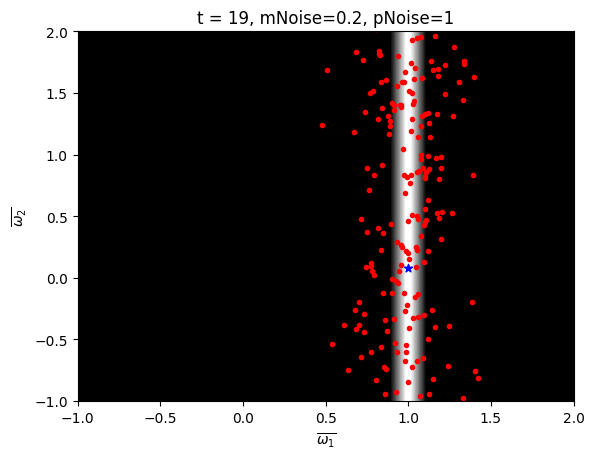

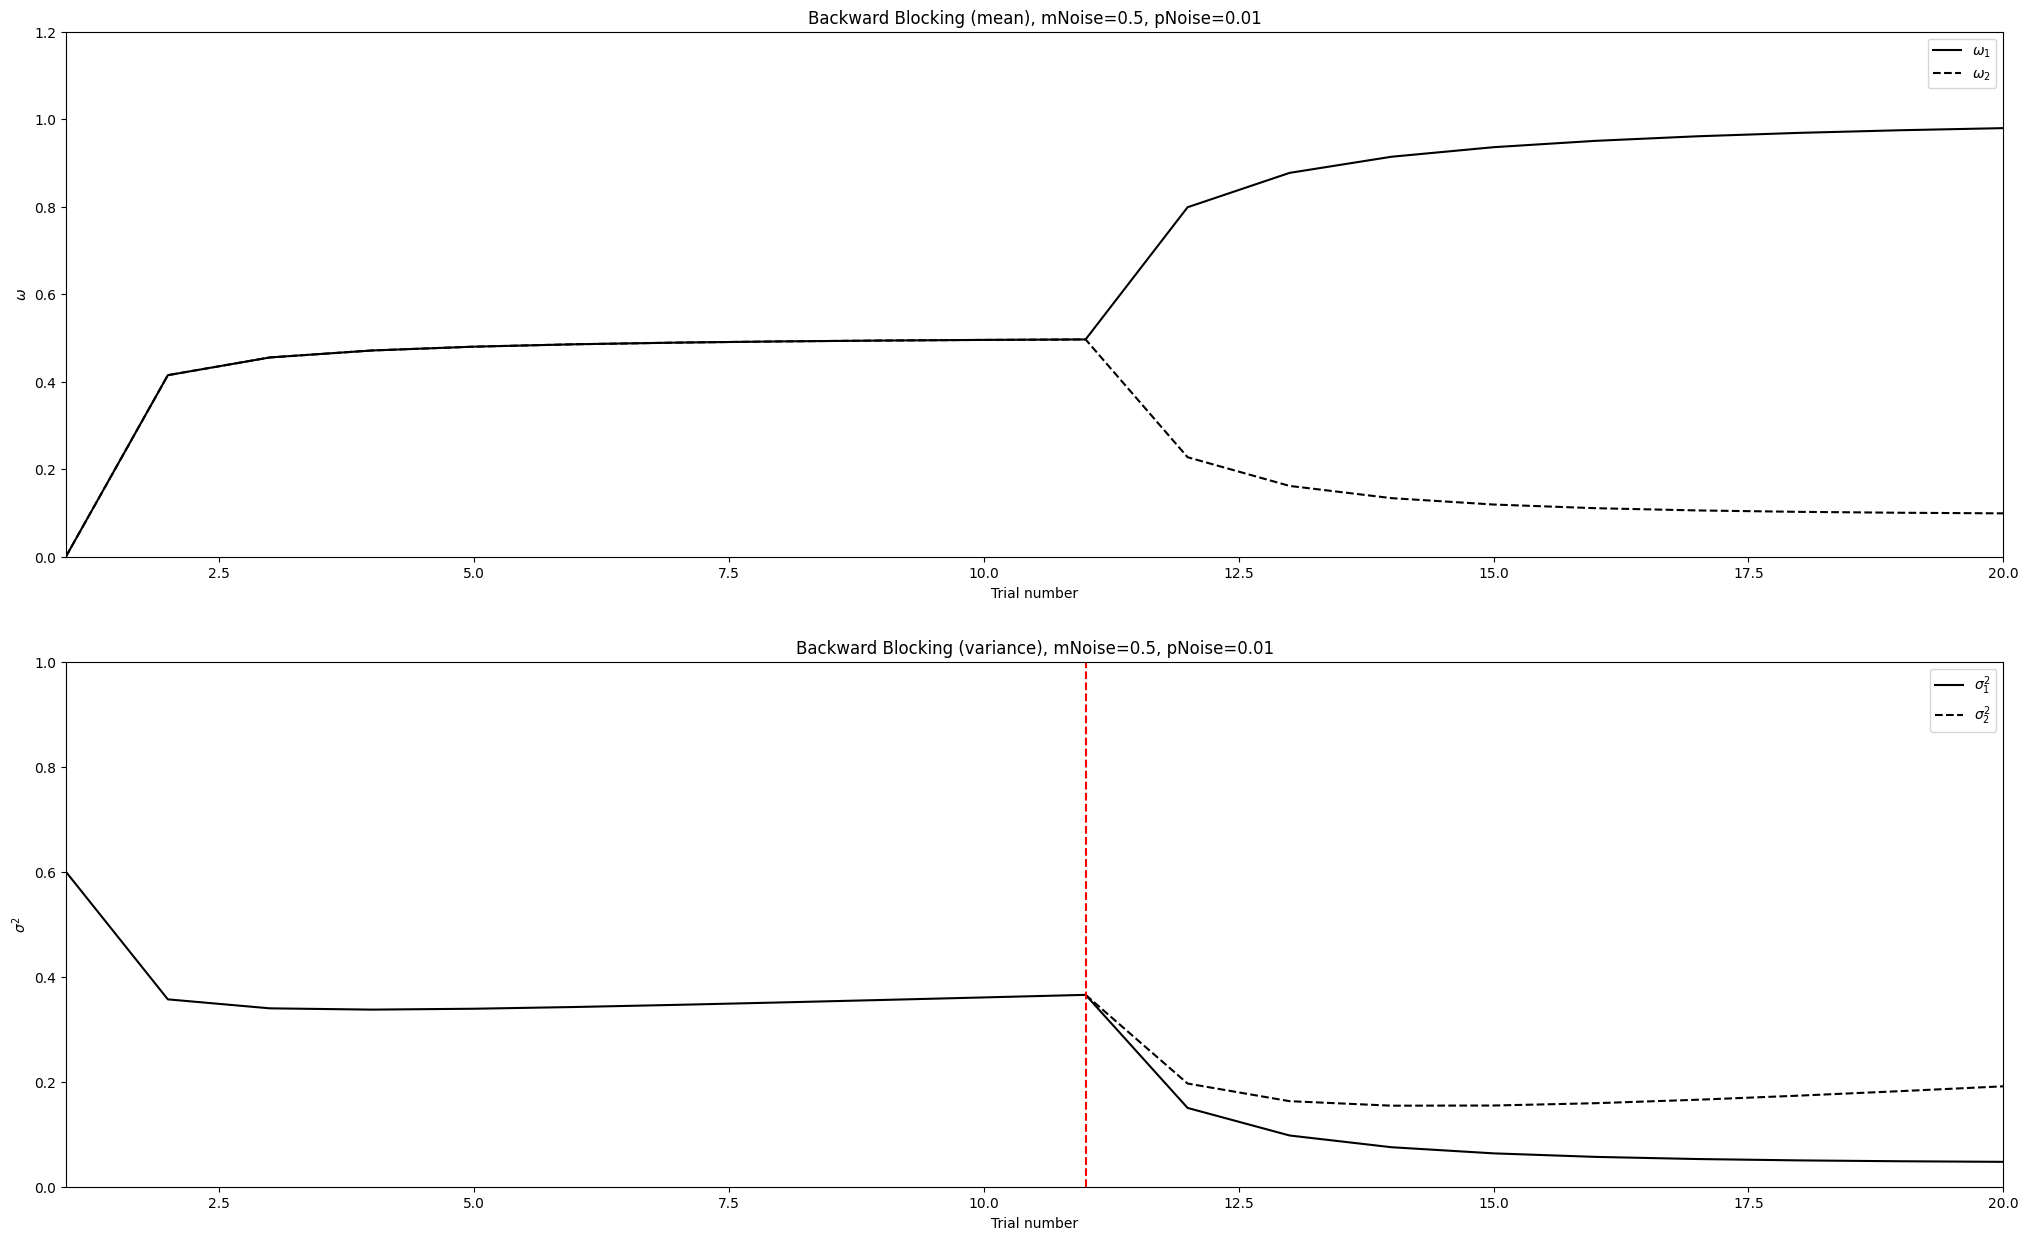

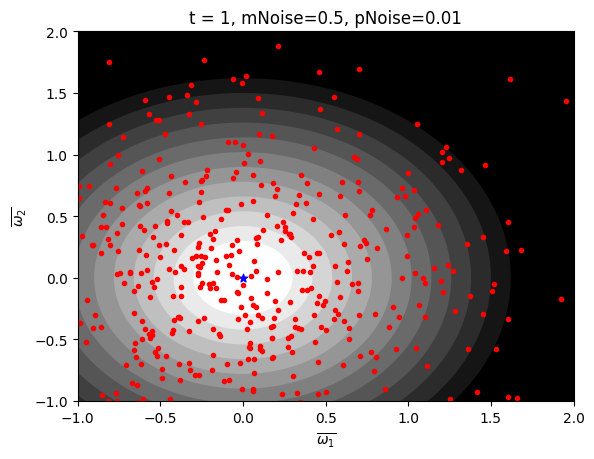

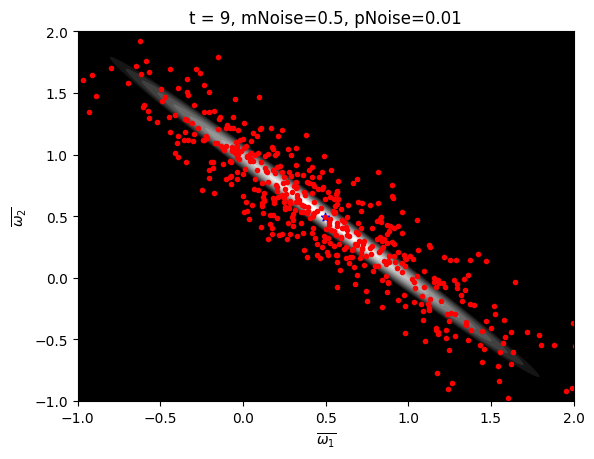

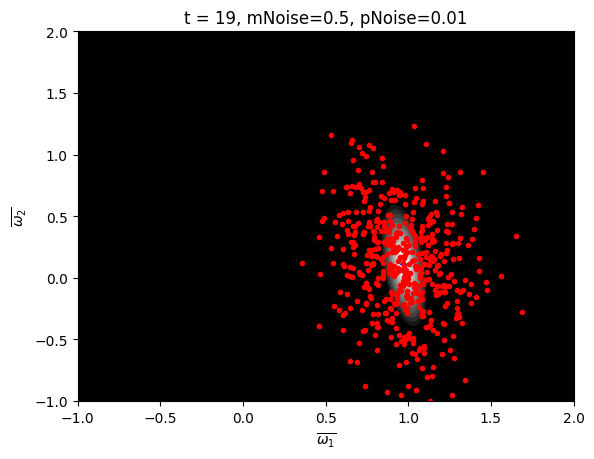

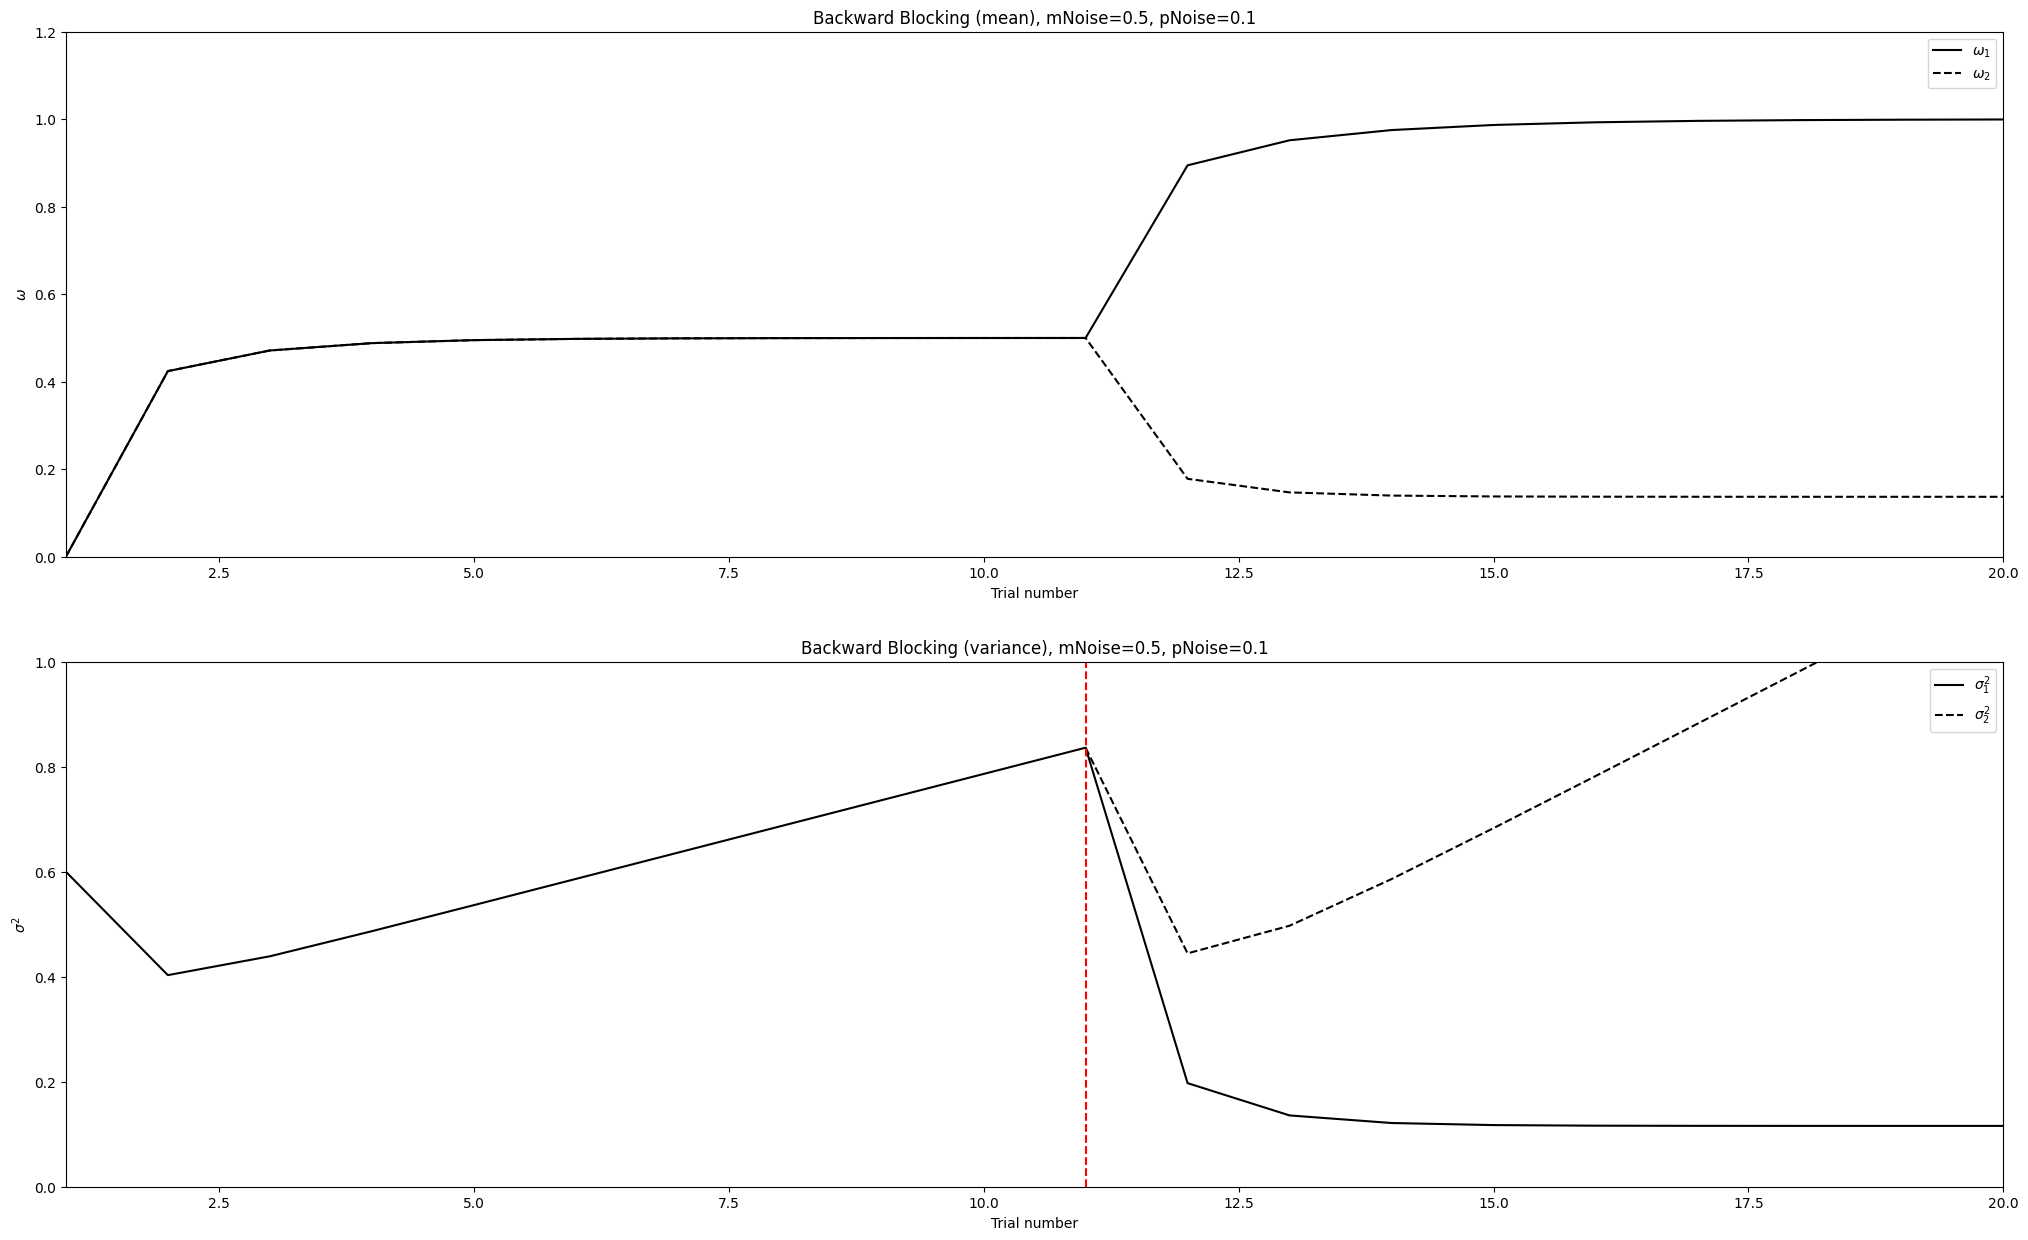

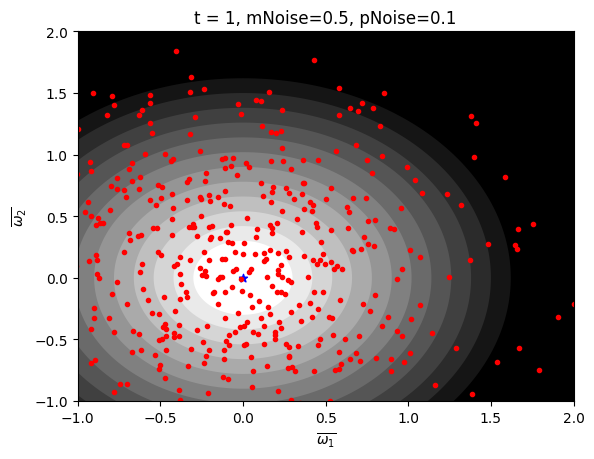

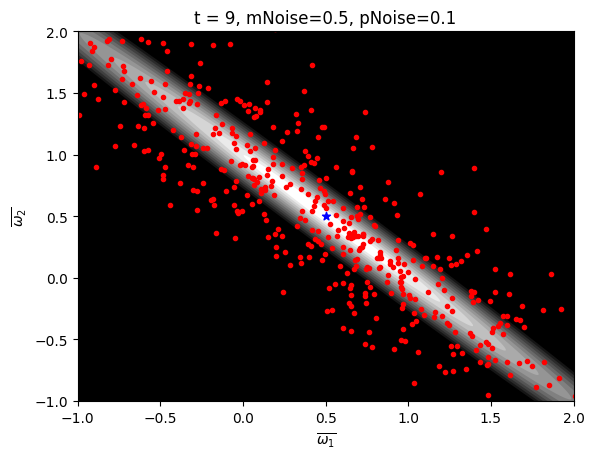

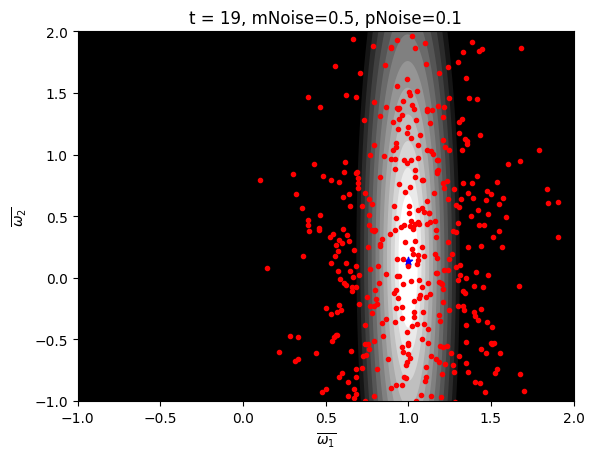

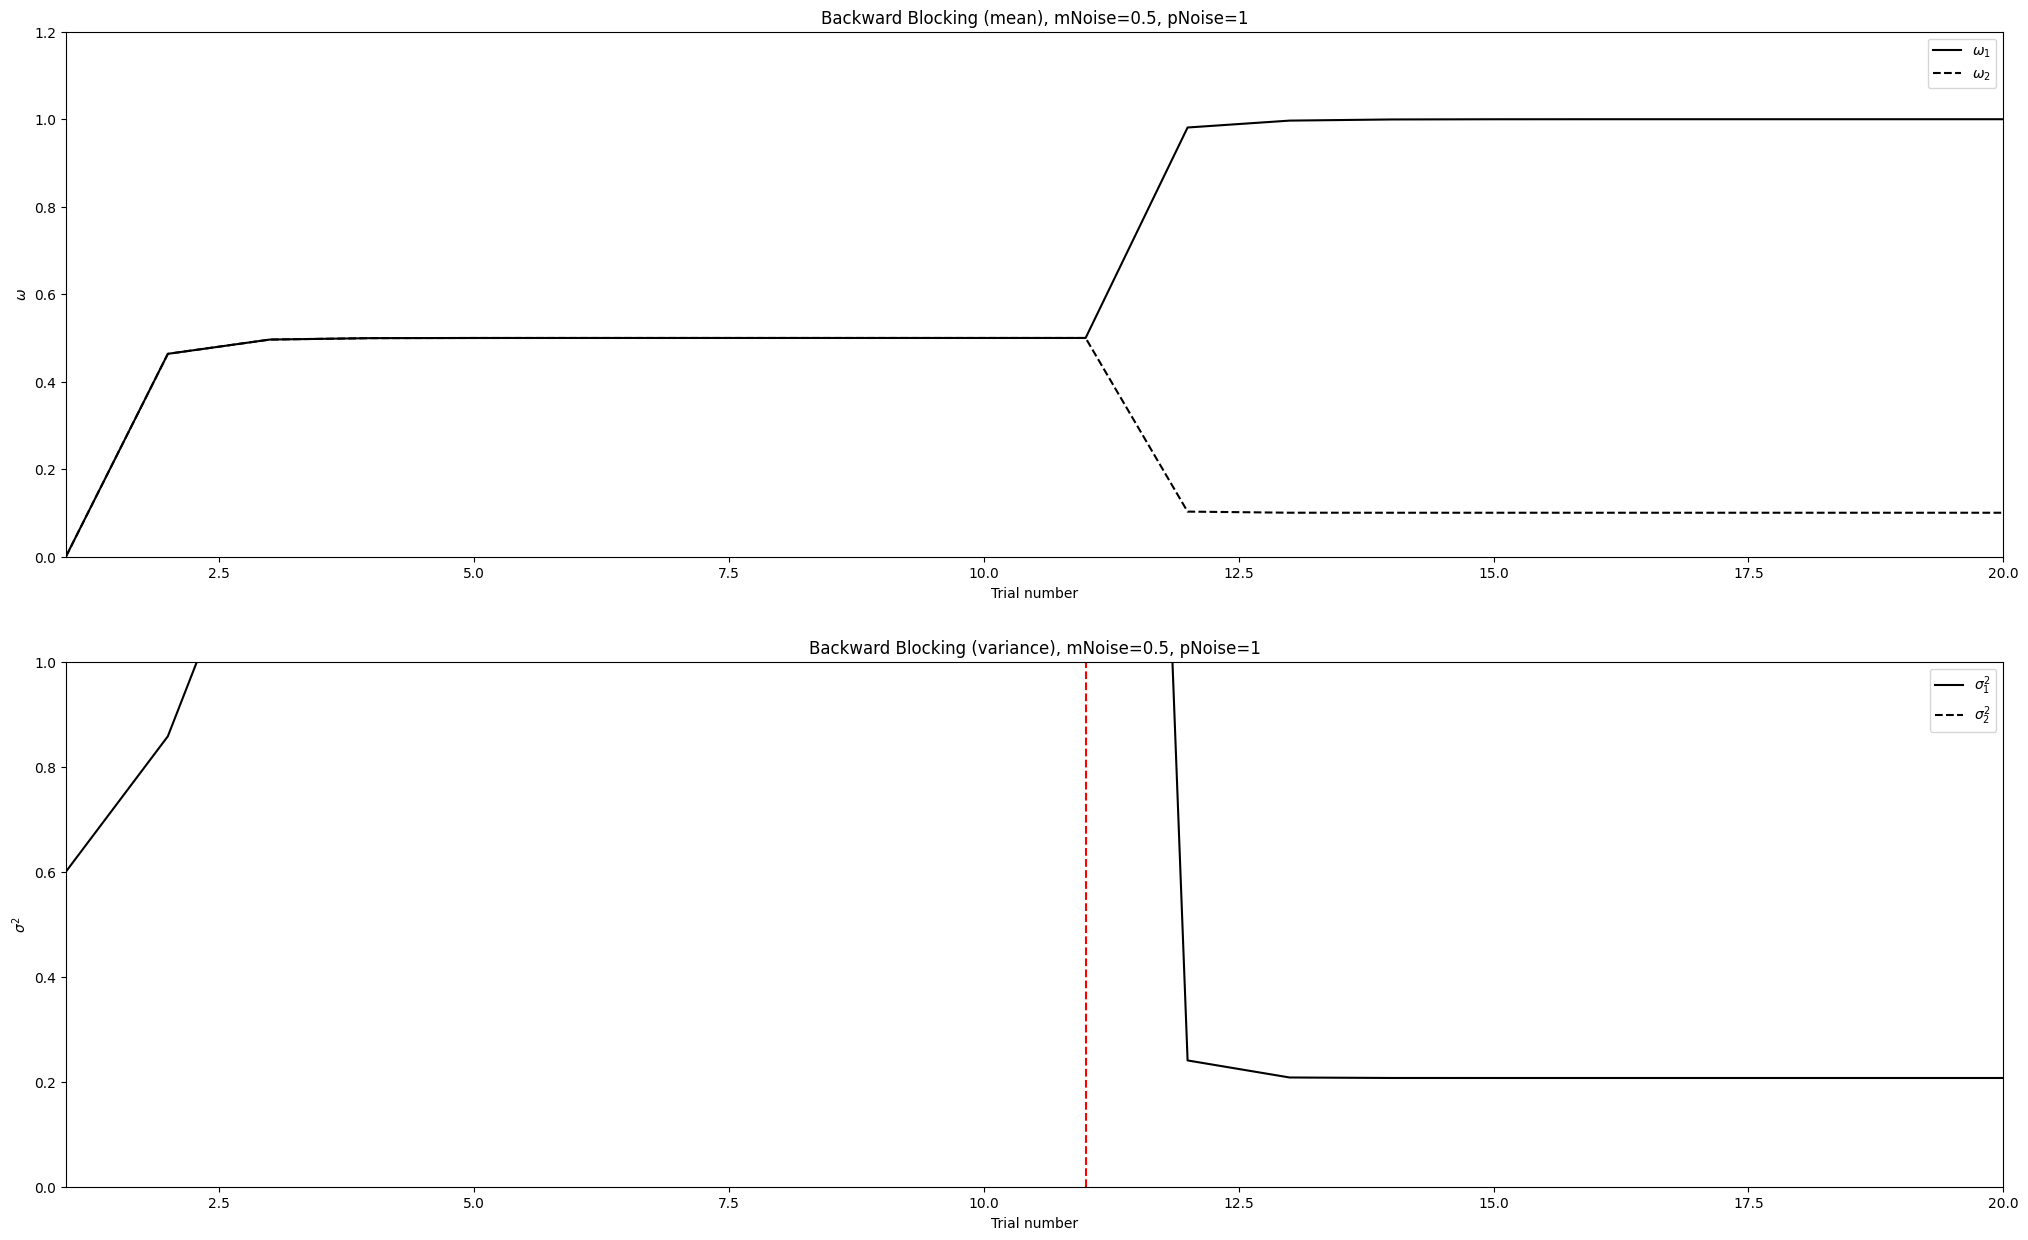

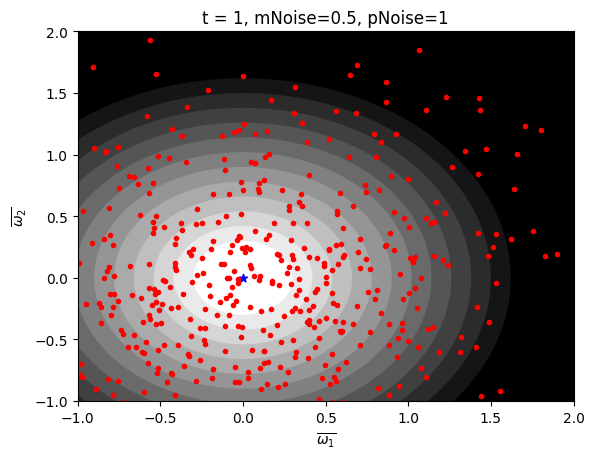

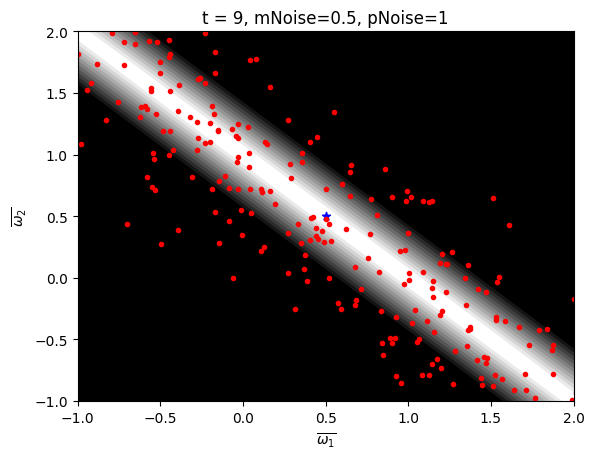

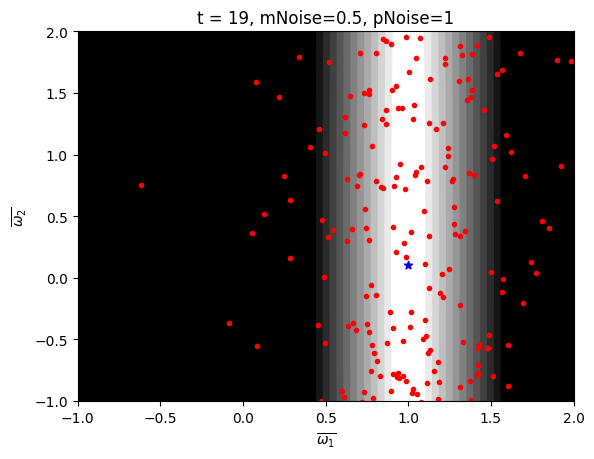

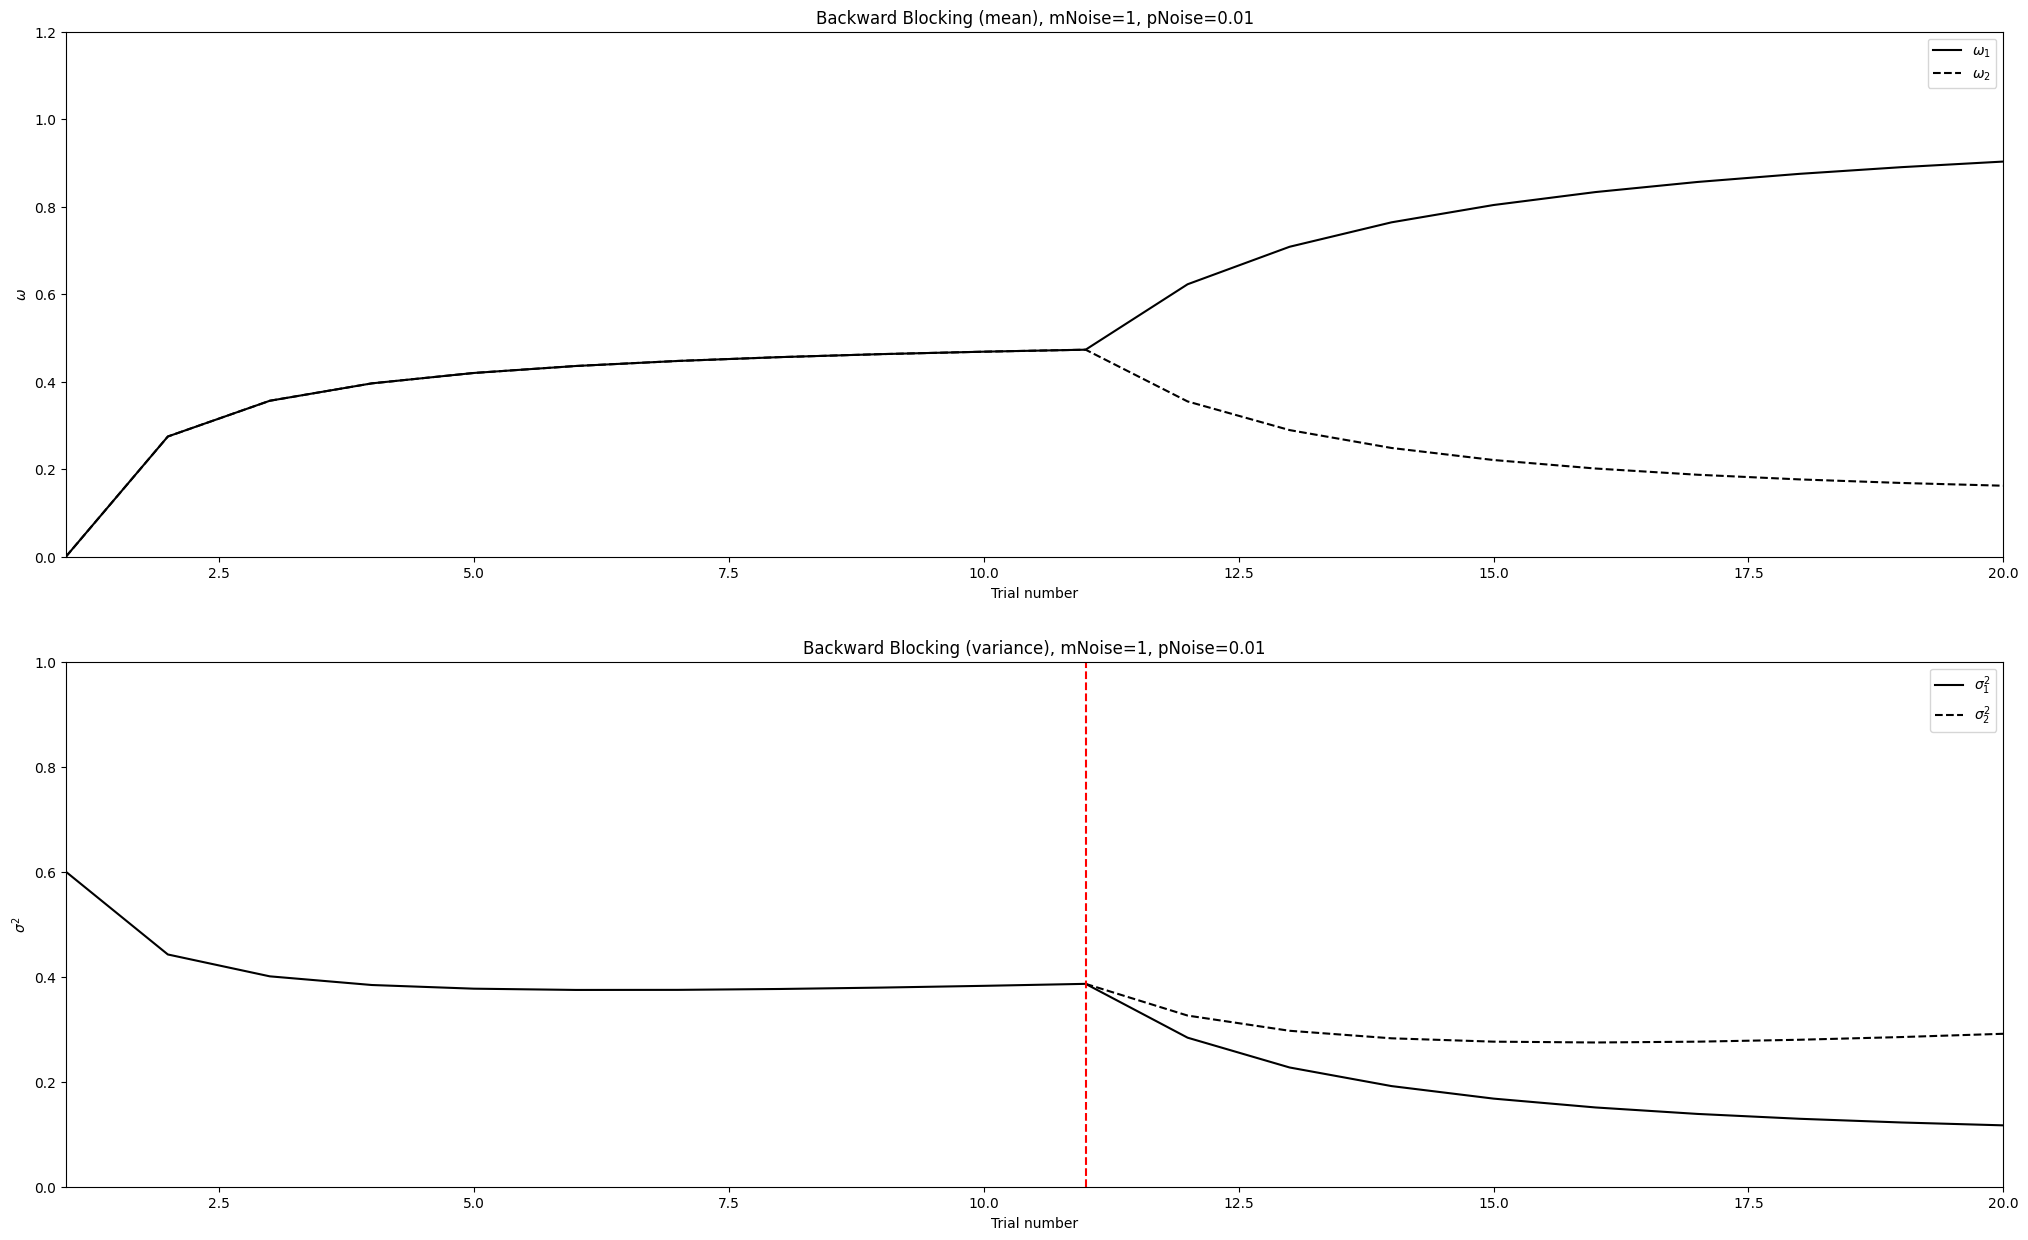

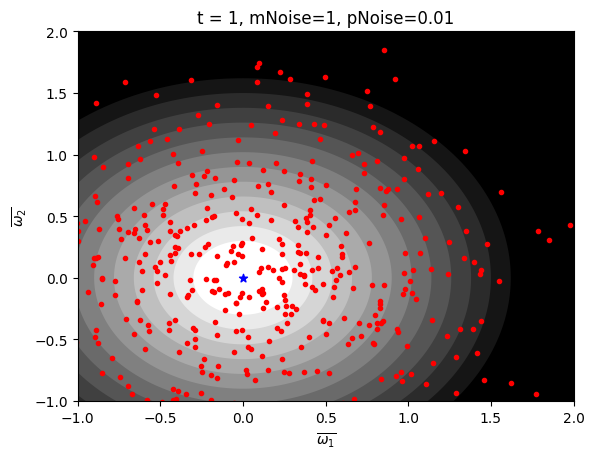

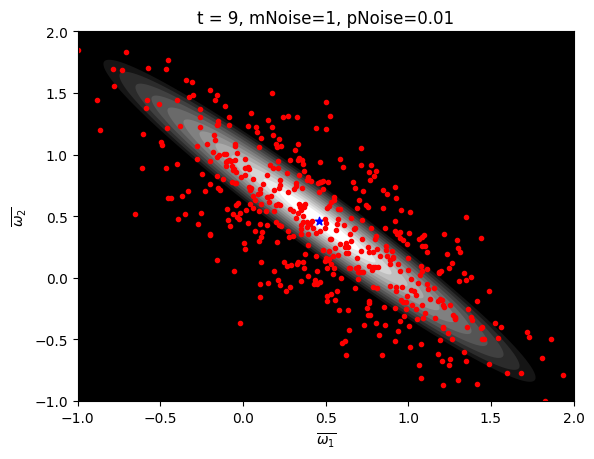

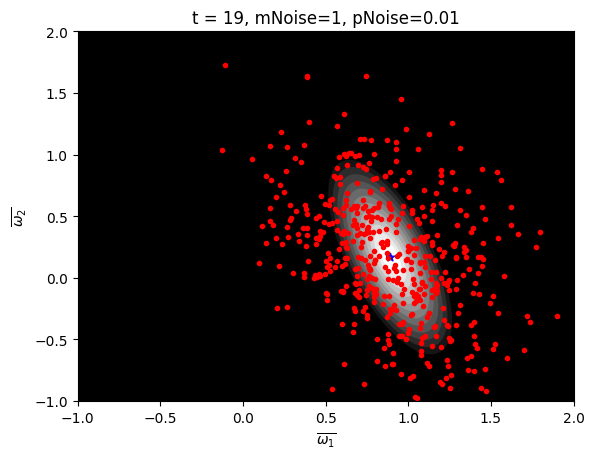

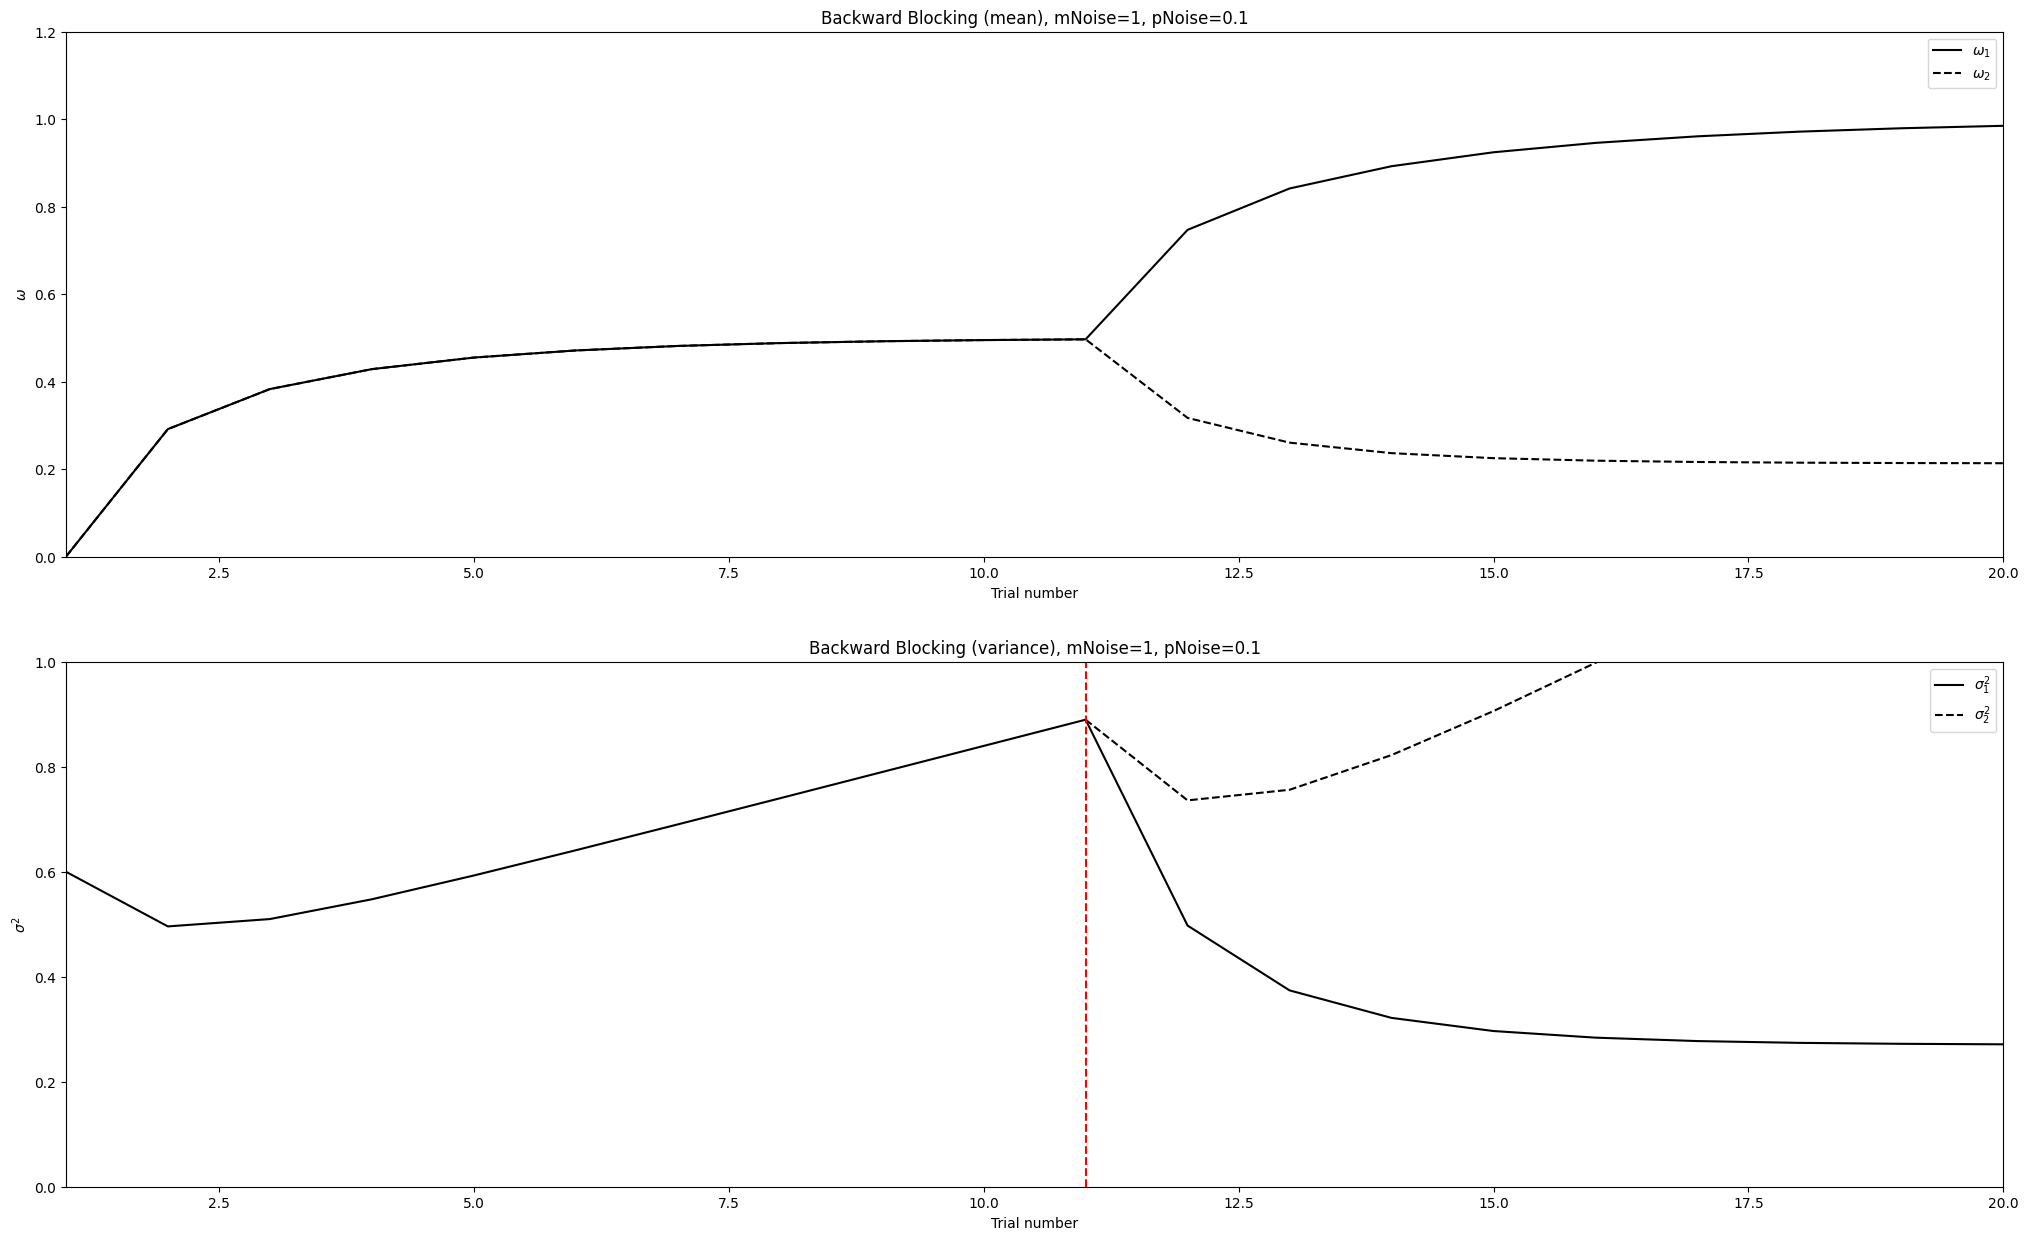

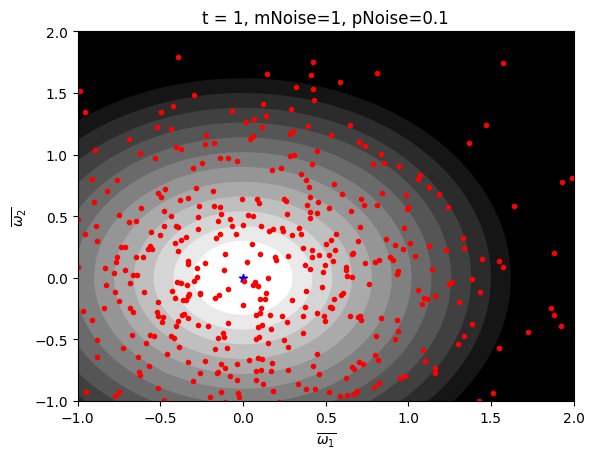

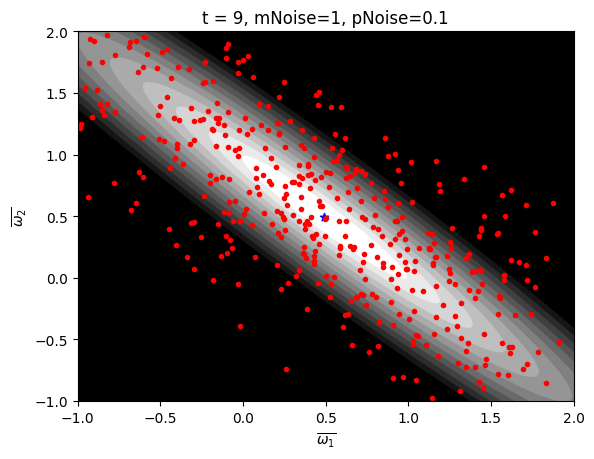

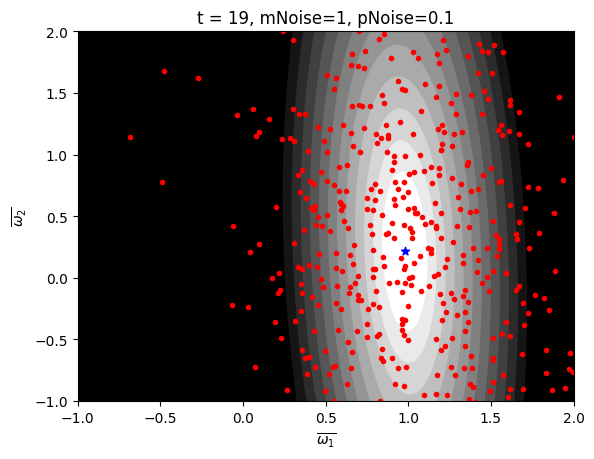

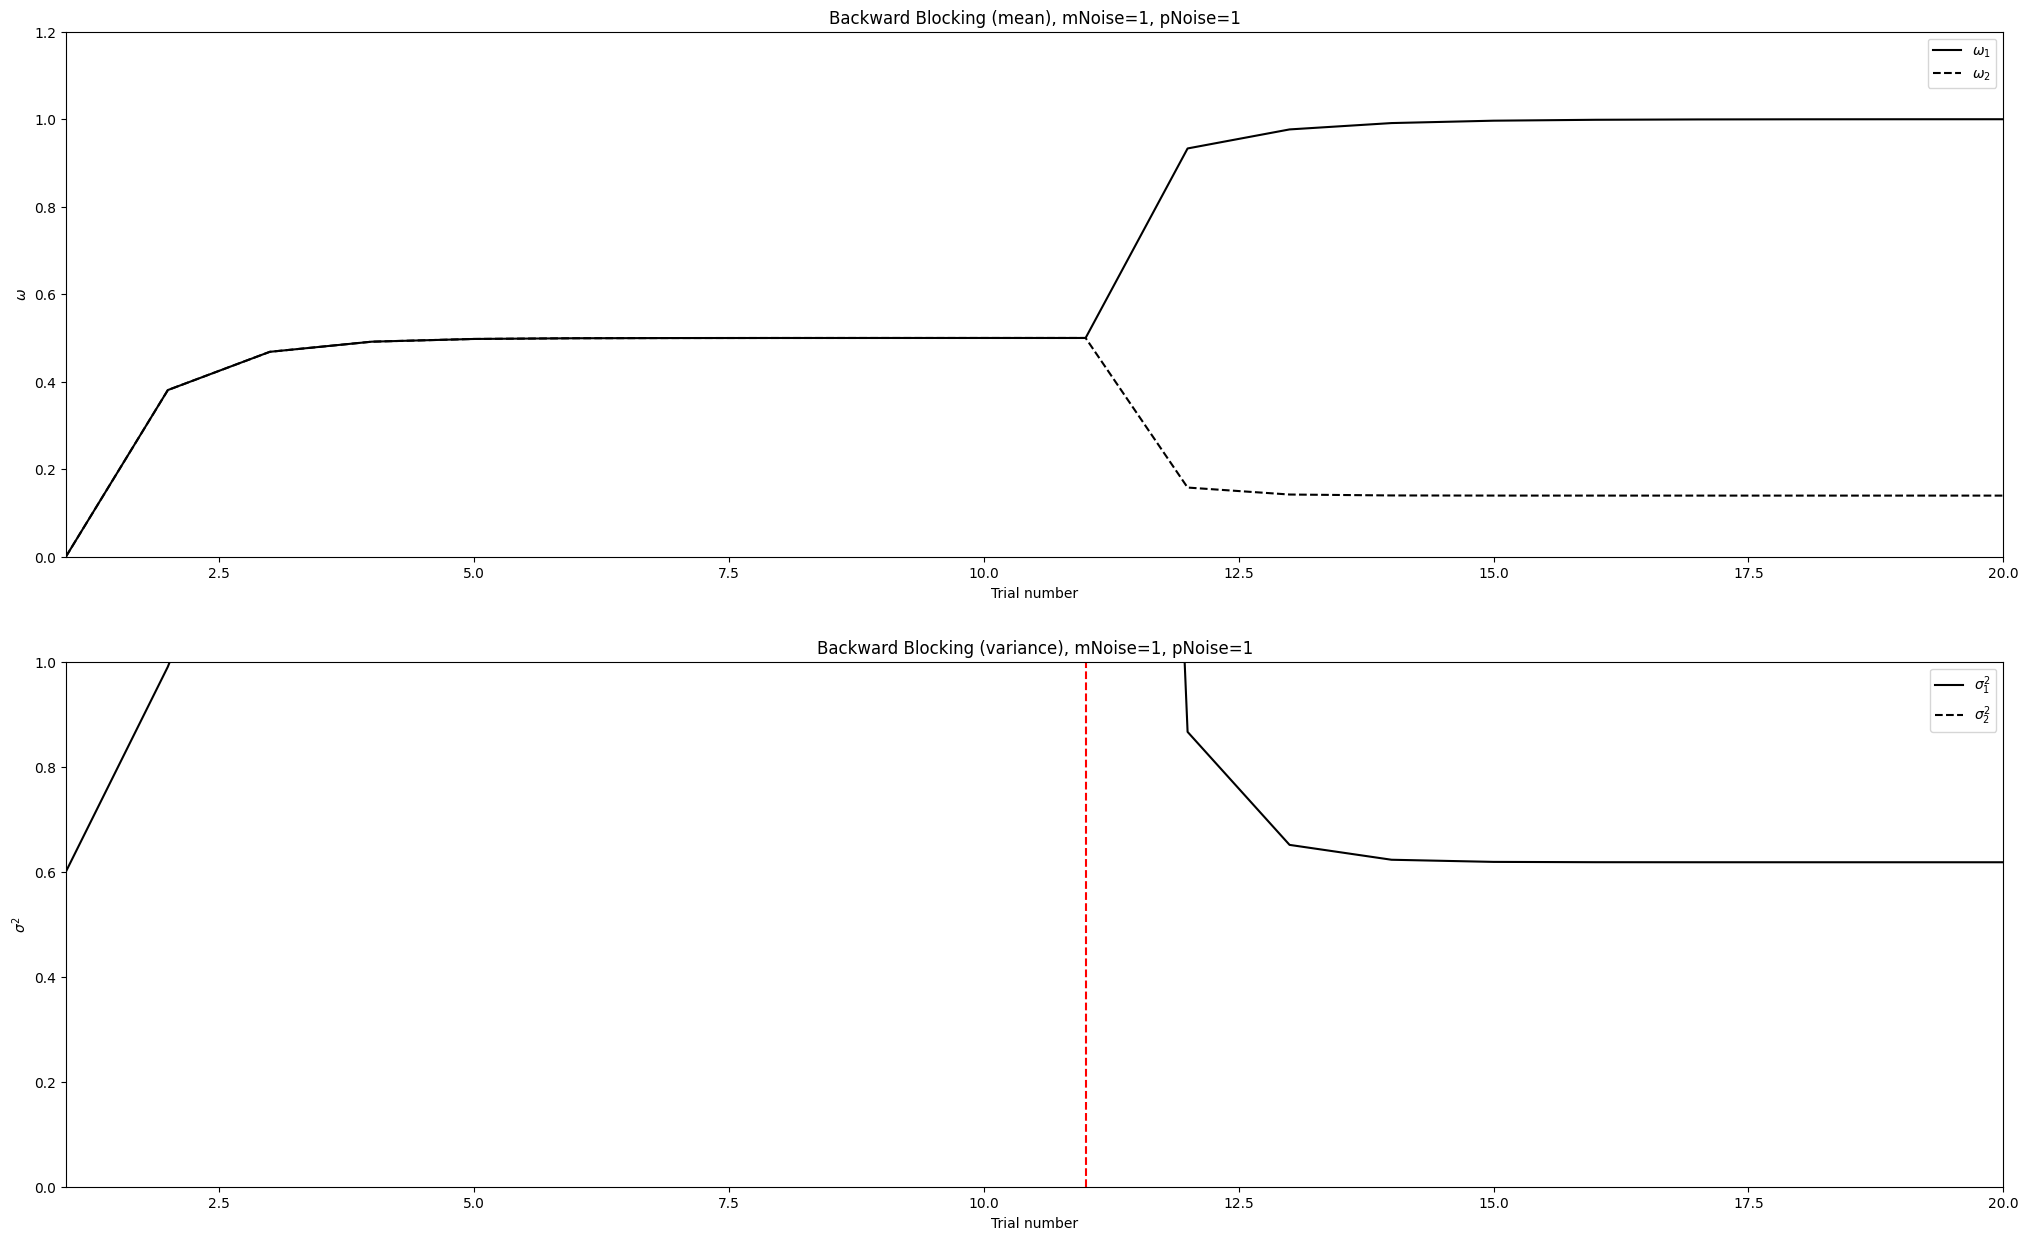

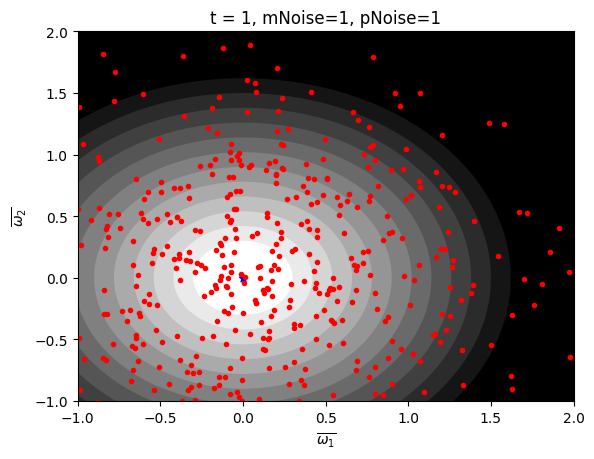

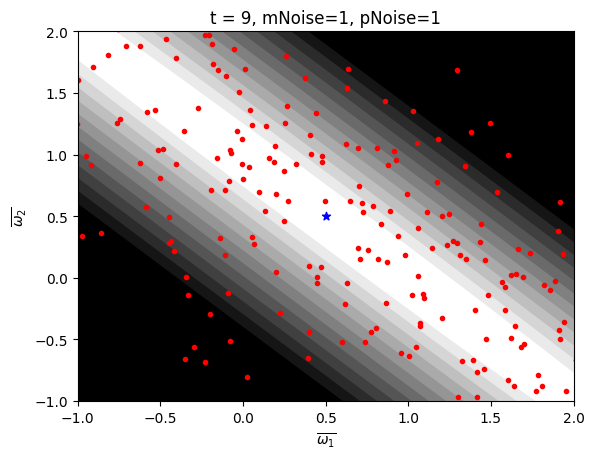

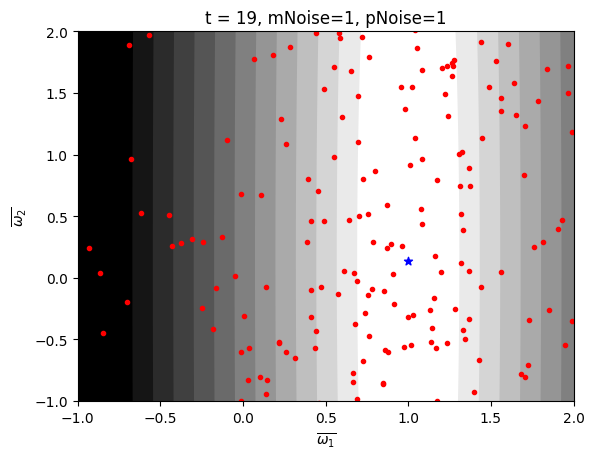

In [13]:
# %% Effect of process noise and measurement noise
taws = [0.2, 0.5, 1]
noisePs = [0.01, 0.1, 1]

for k in range(len(taws)):
    for kk in range(len(noisePs)):
        taw = taws[k]
        noiseP = np.eye(2) * noisePs[kk]
        # Backward Blocking
        fig, ax = plt.subplots(2, 1, figsize=(25, 15))
        numTrials = 20
        u = np.ones((2, numTrials))
        r = np.ones((1, numTrials))
        u[1, int(numTrials/2):] = 0
        w0 = [0, 0]
        cov = np.eye(2) * 0.6
        [weight, covariance] = KalmanFilter(u, r, cov, w0, taw, noiseP, numTrials)
        ax[0].plot(range(1, numTrials+1), weight[0, :], 'k', label = r'$\omega_1$')
        ax[0].plot(range(1, numTrials+1), weight[1, :], '--k', label = r'$\omega_2$')
        ax[0].set_title("Backward Blocking (mean), mNoise=" + str(taw) + ", pNoise=" + str(noisePs[kk]))
        ax[0].set_xlabel("Trial number")
        ax[0].set_ylabel(r'$\omega$')
        ax[0].set_xlim([1, numTrials])
        ax[0].set_ylim([0, 1.2])
        ax[0].legend()

        ax[1].plot(range(1, numTrials + 1), np.squeeze(covariance[0, 0, :]), 'k', label = r'$\sigma_1^2$')
        ax[1].plot(range(int(numTrials/2) + 1, numTrials + 1), np.squeeze(covariance[1, 1, int(numTrials/2):]), '--k', label = r'$\sigma_2^2$')
        ax[1].axvline(x=int(numTrials/2) + 1, linestyle='--', color='r')
        ax[1].set_title("Backward Blocking (variance), mNoise=" + str(taw) + ", pNoise=" + str(noisePs[kk]))
        ax[1].set_xlabel("Trial number")
        ax[1].set_ylabel(r'$\sigma^2$')
        ax[1].set_xlim([1, numTrials])
        ax[1].set_ylim([0, 1])
        ax[1].legend()
        
        
        r_list = np.arange(0.5, 3, 0.2)
        theta = np.arange(0, 2*np.pi, 0.01)
        colors = np.linspace(1, 0, len(r_list))
        i = 0

        for t in [0, 8, 18]:
            plt.figure()
            plt.gca().add_patch(Rectangle((-1, -1), 3, 3 , facecolor='k', alpha=1))
            covarianceC = covariance[:, :, t]
            weightC = weight[:, t]
            j = len(r_list)-1
            for r in r_list[::-1]:
                x = np.sin(theta) * r
                y = np.cos(theta) * r
                tmp = np.matmul(covarianceC, np.vstack((x, y)))        
                x = weightC[0] + tmp[0, :]
                y = weightC[1] + tmp[1, :]
                fill_color = np.array([1, 1, 1]) * colors[j]
                plt.fill(x, y, facecolor=fill_color, edgecolor='none')
                j = j - 1
            plt.scatter(weightC[0], weightC[1], c='b', marker='*')
            generatedData = np.random.multivariate_normal(weightC, covarianceC, size=500)
            plt.scatter(generatedData[:, 0], generatedData[:, 1], c='r', marker='.')
            plt.xlabel(r'$\overline {\omega_1}$')
            plt.ylabel(r'$\overline {\omega_2}$')
            plt.title("t = {}, ".format(t+1) + "mNoise=" + str(taw) + ", pNoise=" + str(noisePs[kk]))
            i += 1
            plt.xlim([-1, 2])
            plt.ylim([-1, 2])

The figures depict the impact of process and measurement noises on the mean and variance of weights. As depicted in the figures, when the measurement noise is greater, the weights exhibit slower changes due to the noisier environment, necessitating more observations for weight updates. Conversely, when the process noise is larger, weight changes occur more rapidly due to larger alterations in the covariance matrix. As the agent's uncertainty regarding the environment grows, the weights adjust more rapidly to gather additional information.

---

### Q3
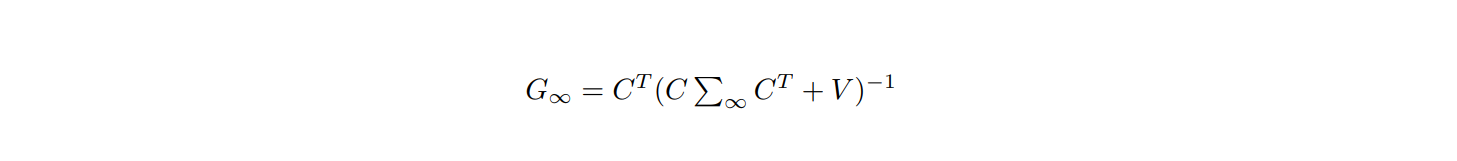

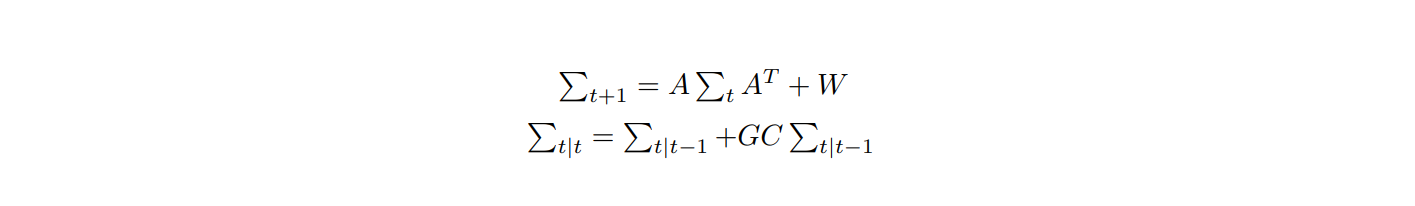

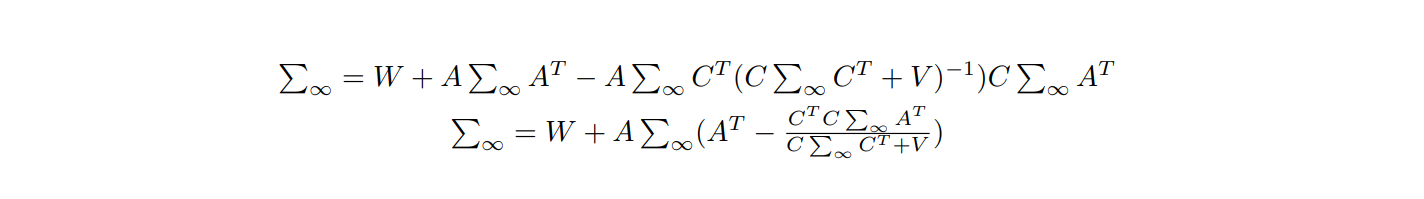

As can be seen in the equations above, the steady-state Kalman gain depends on A, V (measurement noise), C, and the covariance matrix.

---

### Q4
In the Kalman Filter formulation, uncertainty changes are independent of errors, implying that the model won't elevate uncertainty regarding the stimulus value even when the stimulus alters. However, in reality, uncertainty changes are reliant on errors made in each trial.

---

### Q5

#### 1) s1 --> 'r'     2) s1 --> '-r'


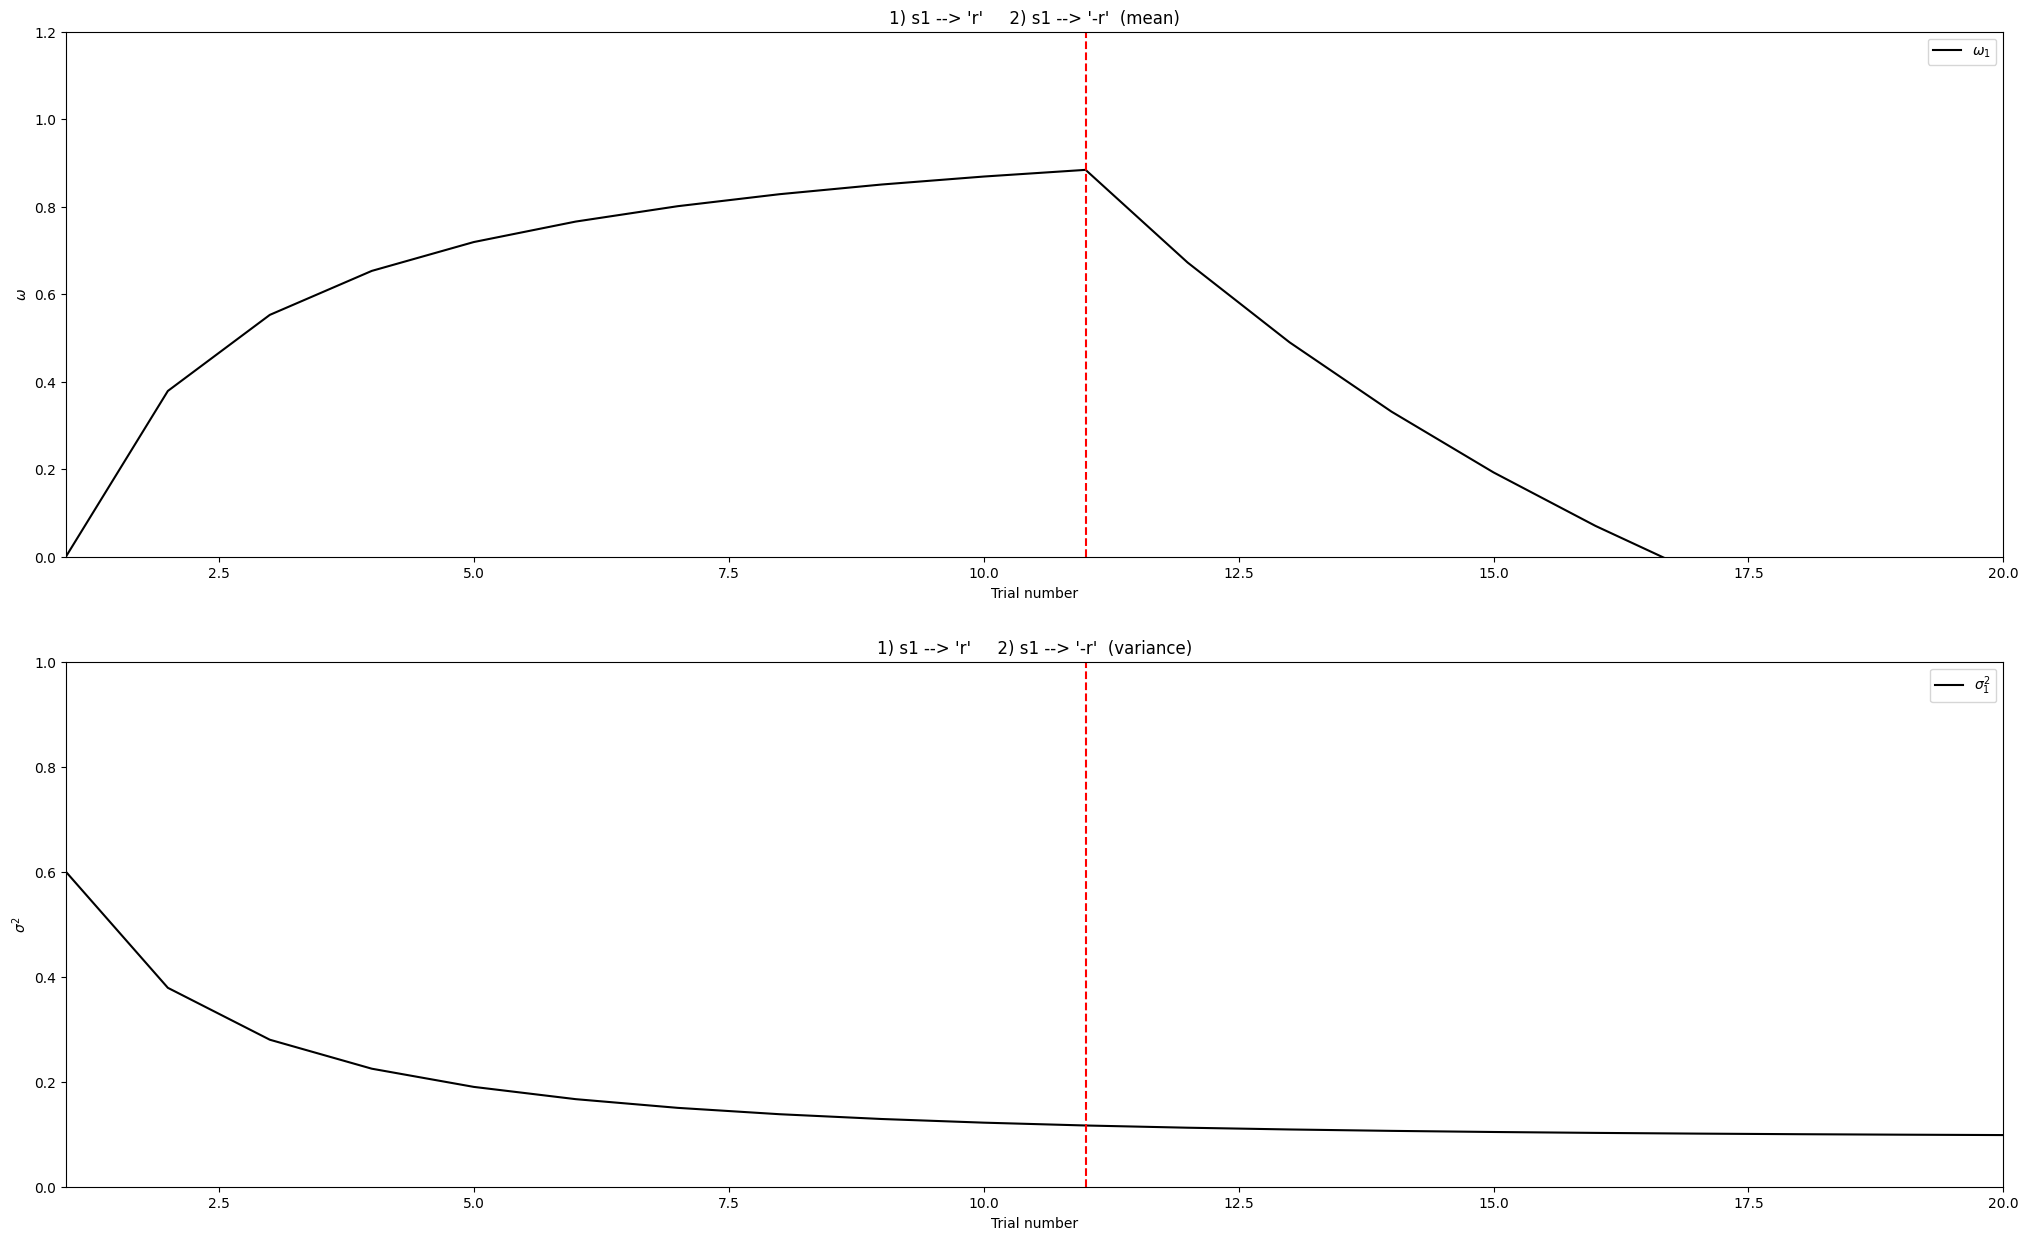

In [14]:
# %% 1) s1 --> 'r'     2) s1 --> '-r'
numTrials = 20
taw = 1
u = np.ones((2, numTrials))
r = np.ones((1, numTrials))
u[1, :] = 0
r[0, int(numTrials/2):] = -1
w0 = [0, 0]
cov = np.eye(2) * 0.6
noiseP = np.eye(2) * 0.01
[weight, covariance] = KalmanFilter(u, r, cov, w0, taw, noiseP, numTrials)

fig, ax = plt.subplots(2, 1, figsize=(25, 15))

ax[0].plot(range(1, numTrials + 1), weight[0, :], 'k', label = r'$\omega_1$')
ax[0].axvline(x=int(numTrials/2) + 1, linestyle='--', color='r')
ax[0].set_title("1) s1 --> 'r'     2) s1 --> '-r'  (mean)")
ax[0].set_xlabel("Trial number")
ax[0].set_ylabel(r'$\omega$')
ax[0].set_xlim([1, numTrials])
ax[0].set_ylim([0, 1.2])
ax[0].legend()

ax[1].plot(range(1, numTrials + 1), np.squeeze(covariance[0, 0, :]), 'k', label = r'$\sigma_1^2$')
ax[1].axvline(x=int(numTrials/2) + 1, linestyle='--', color='r')
ax[1].set_title("1) s1 --> 'r'     2) s1 --> '-r'  (variance)")
ax[1].set_xlabel("Trial number")
ax[1].set_ylabel(r'$\sigma^2$')
ax[1].set_xlim([1, numTrials])
ax[1].set_ylim([0, 1])
ax[1].legend();

The figure demonstrates that despite alterations in the stimulus value, the uncertainty regarding the stimulus remains constant. Furthermore, in the initial stage, the learning rate increases owing to weight increment.

---

## Part 3
### Q1
#### Figure 3


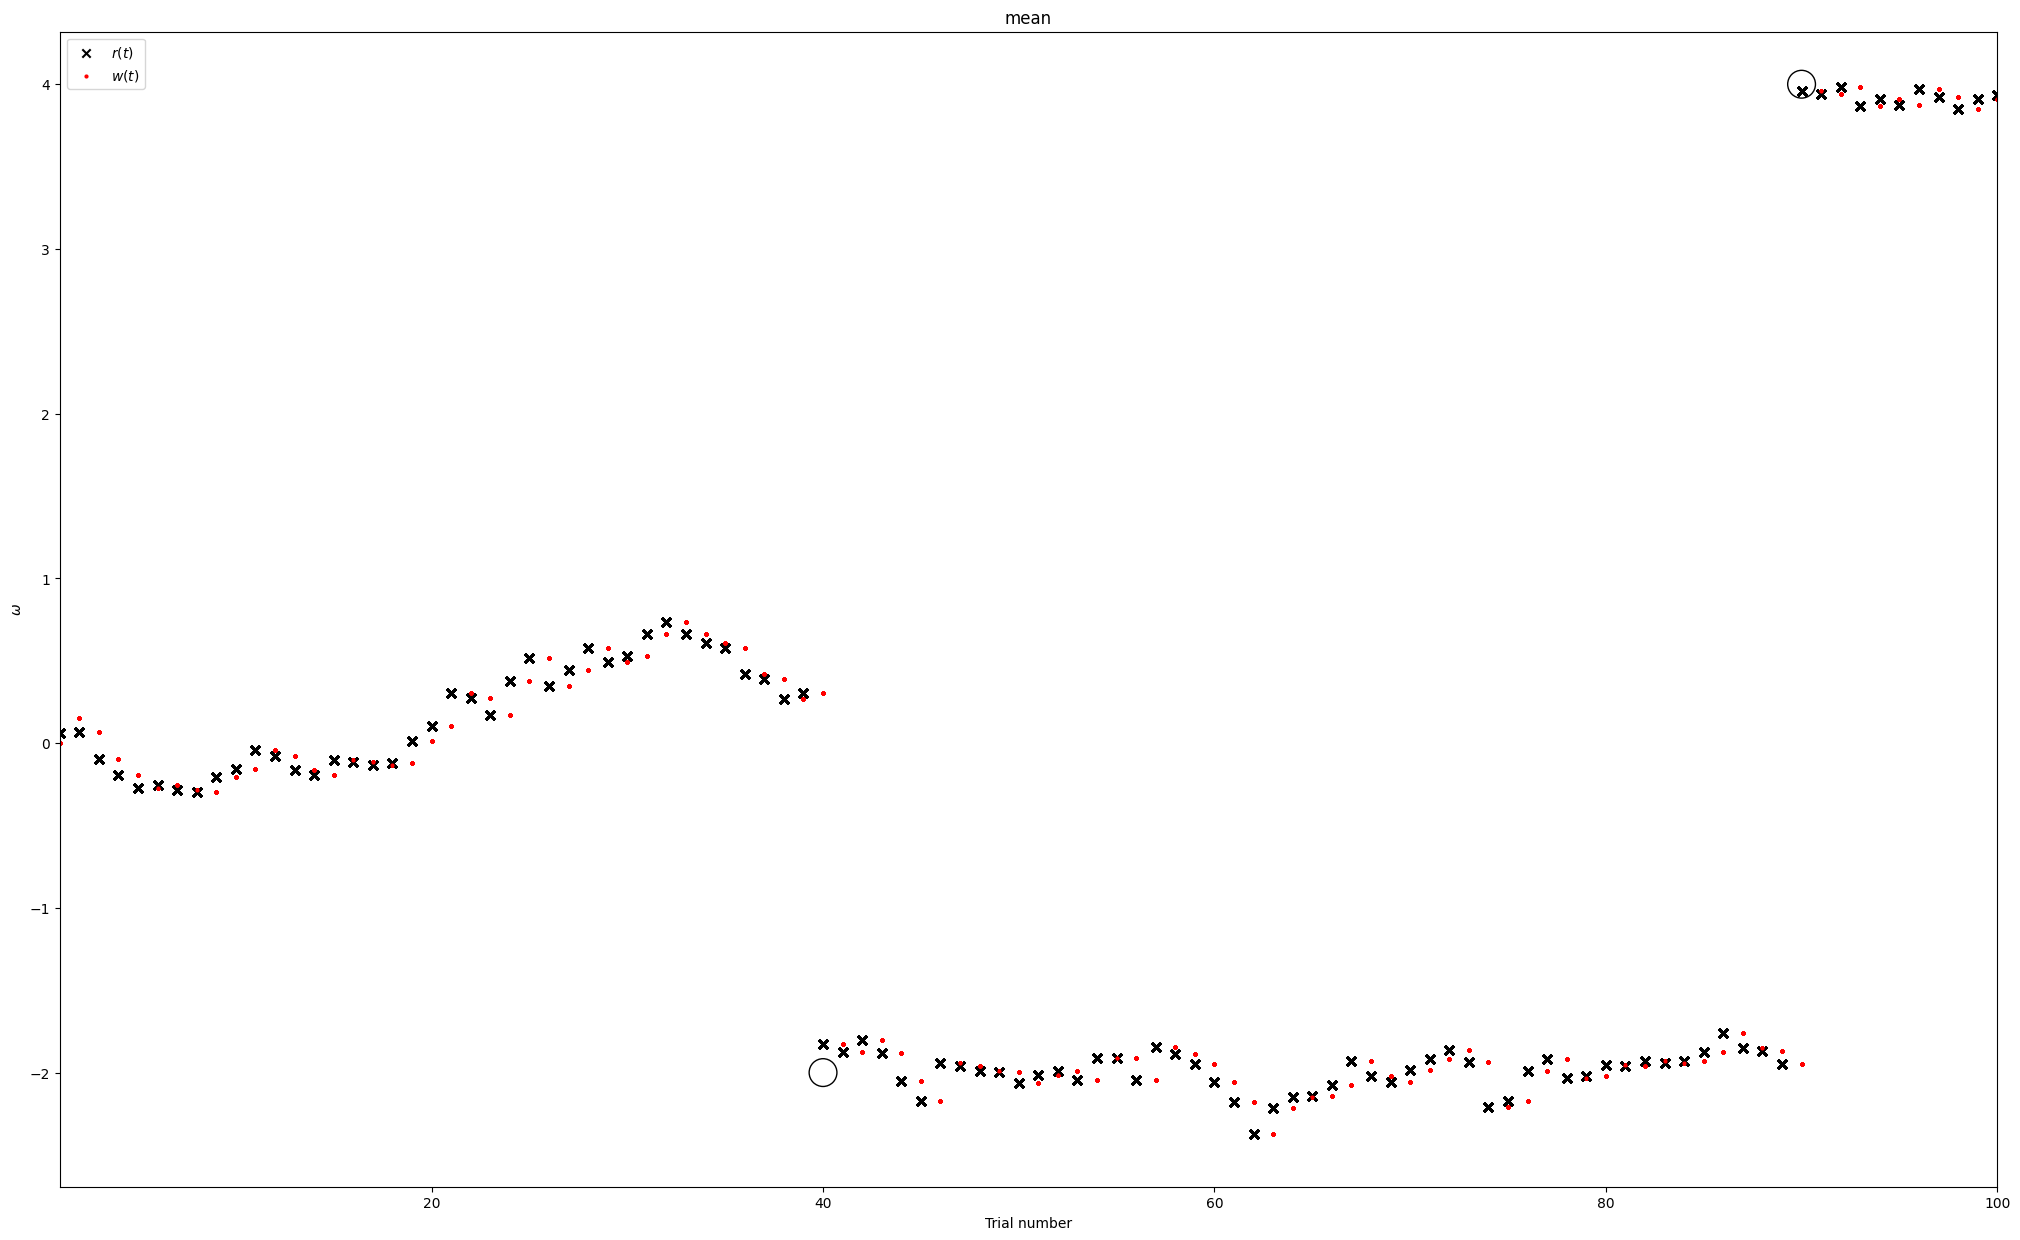

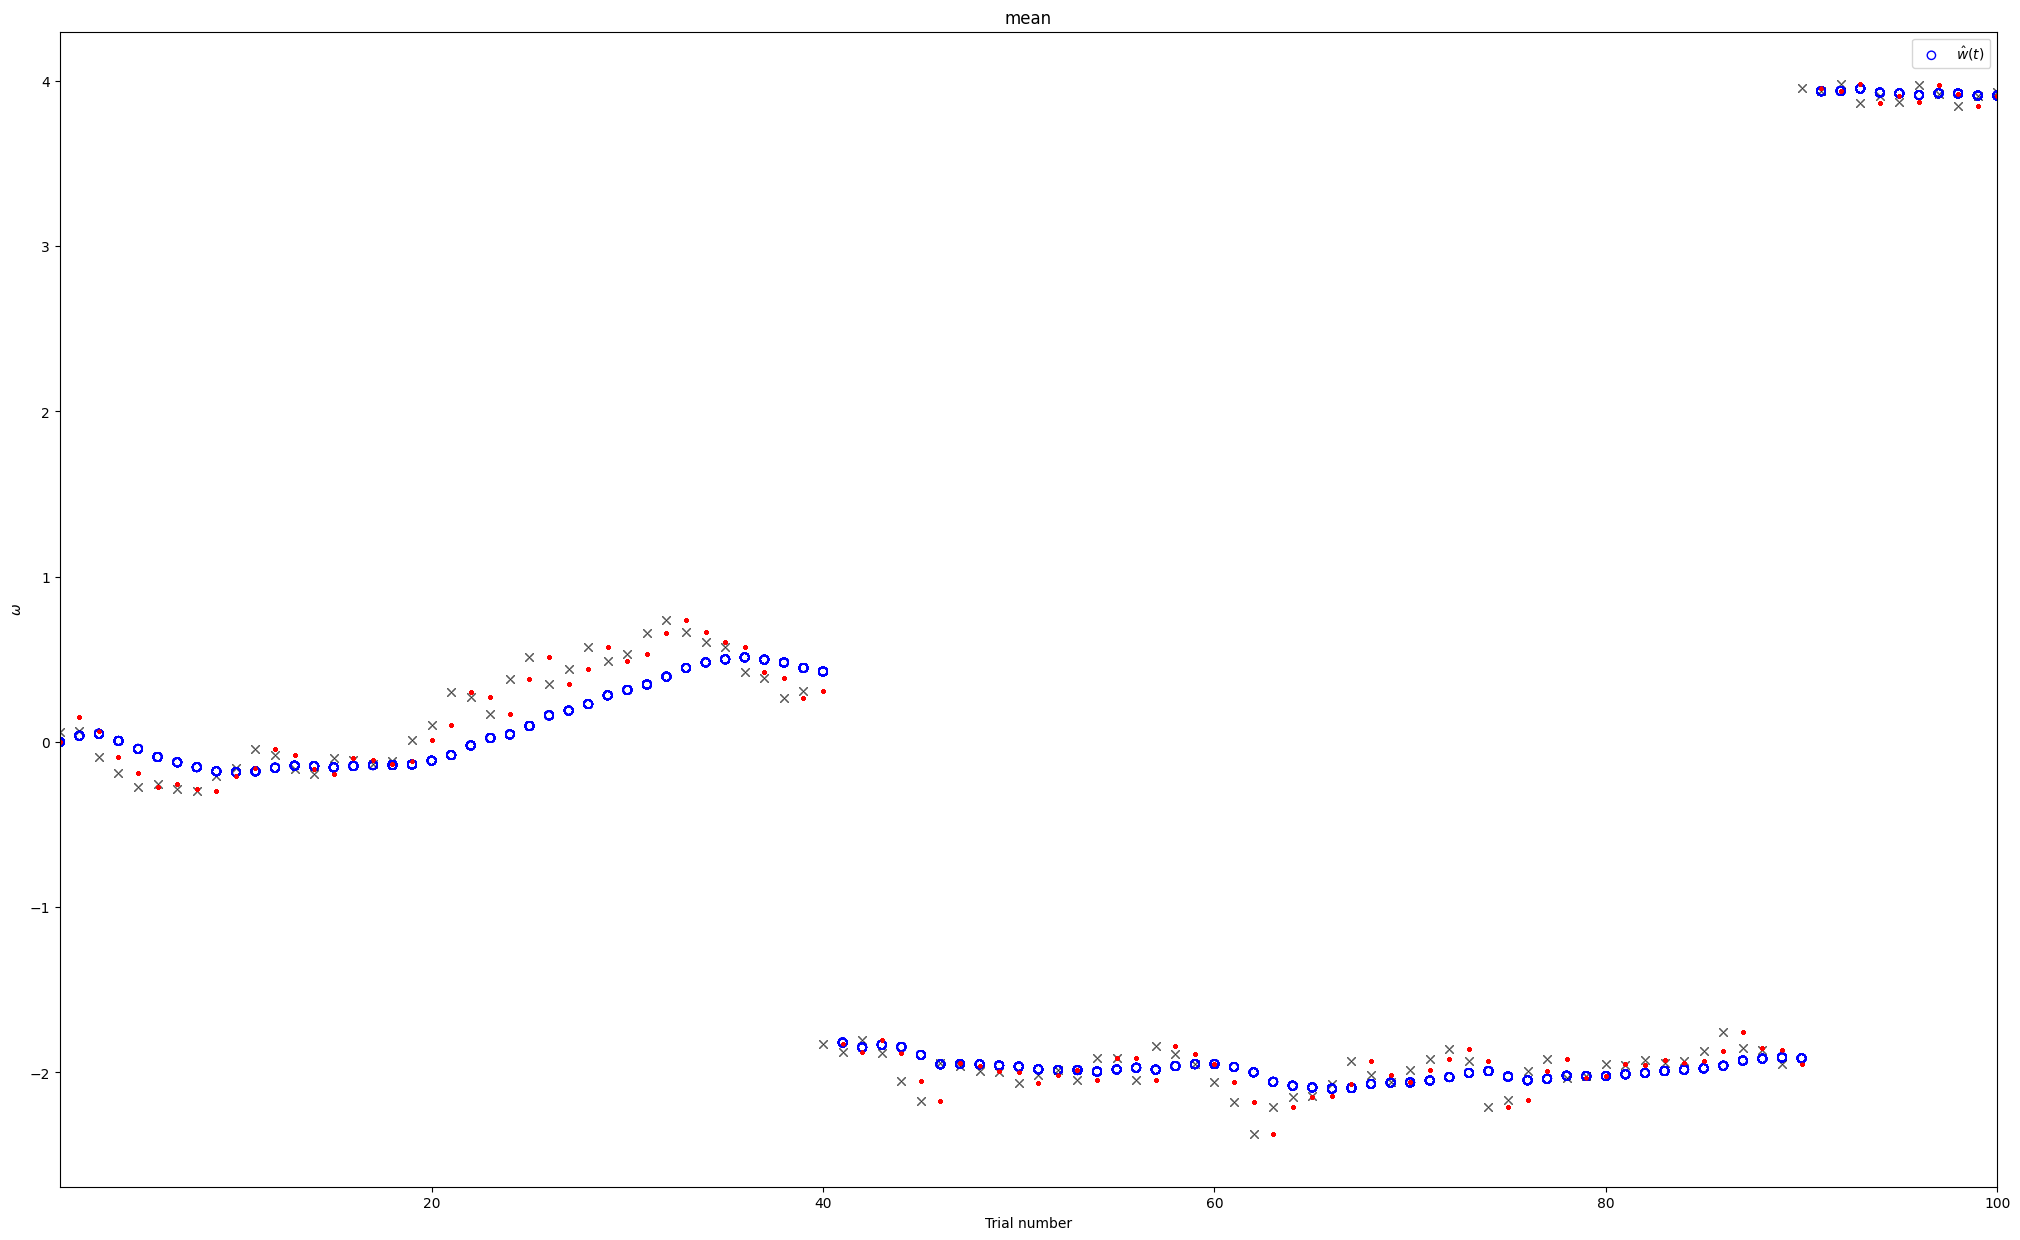

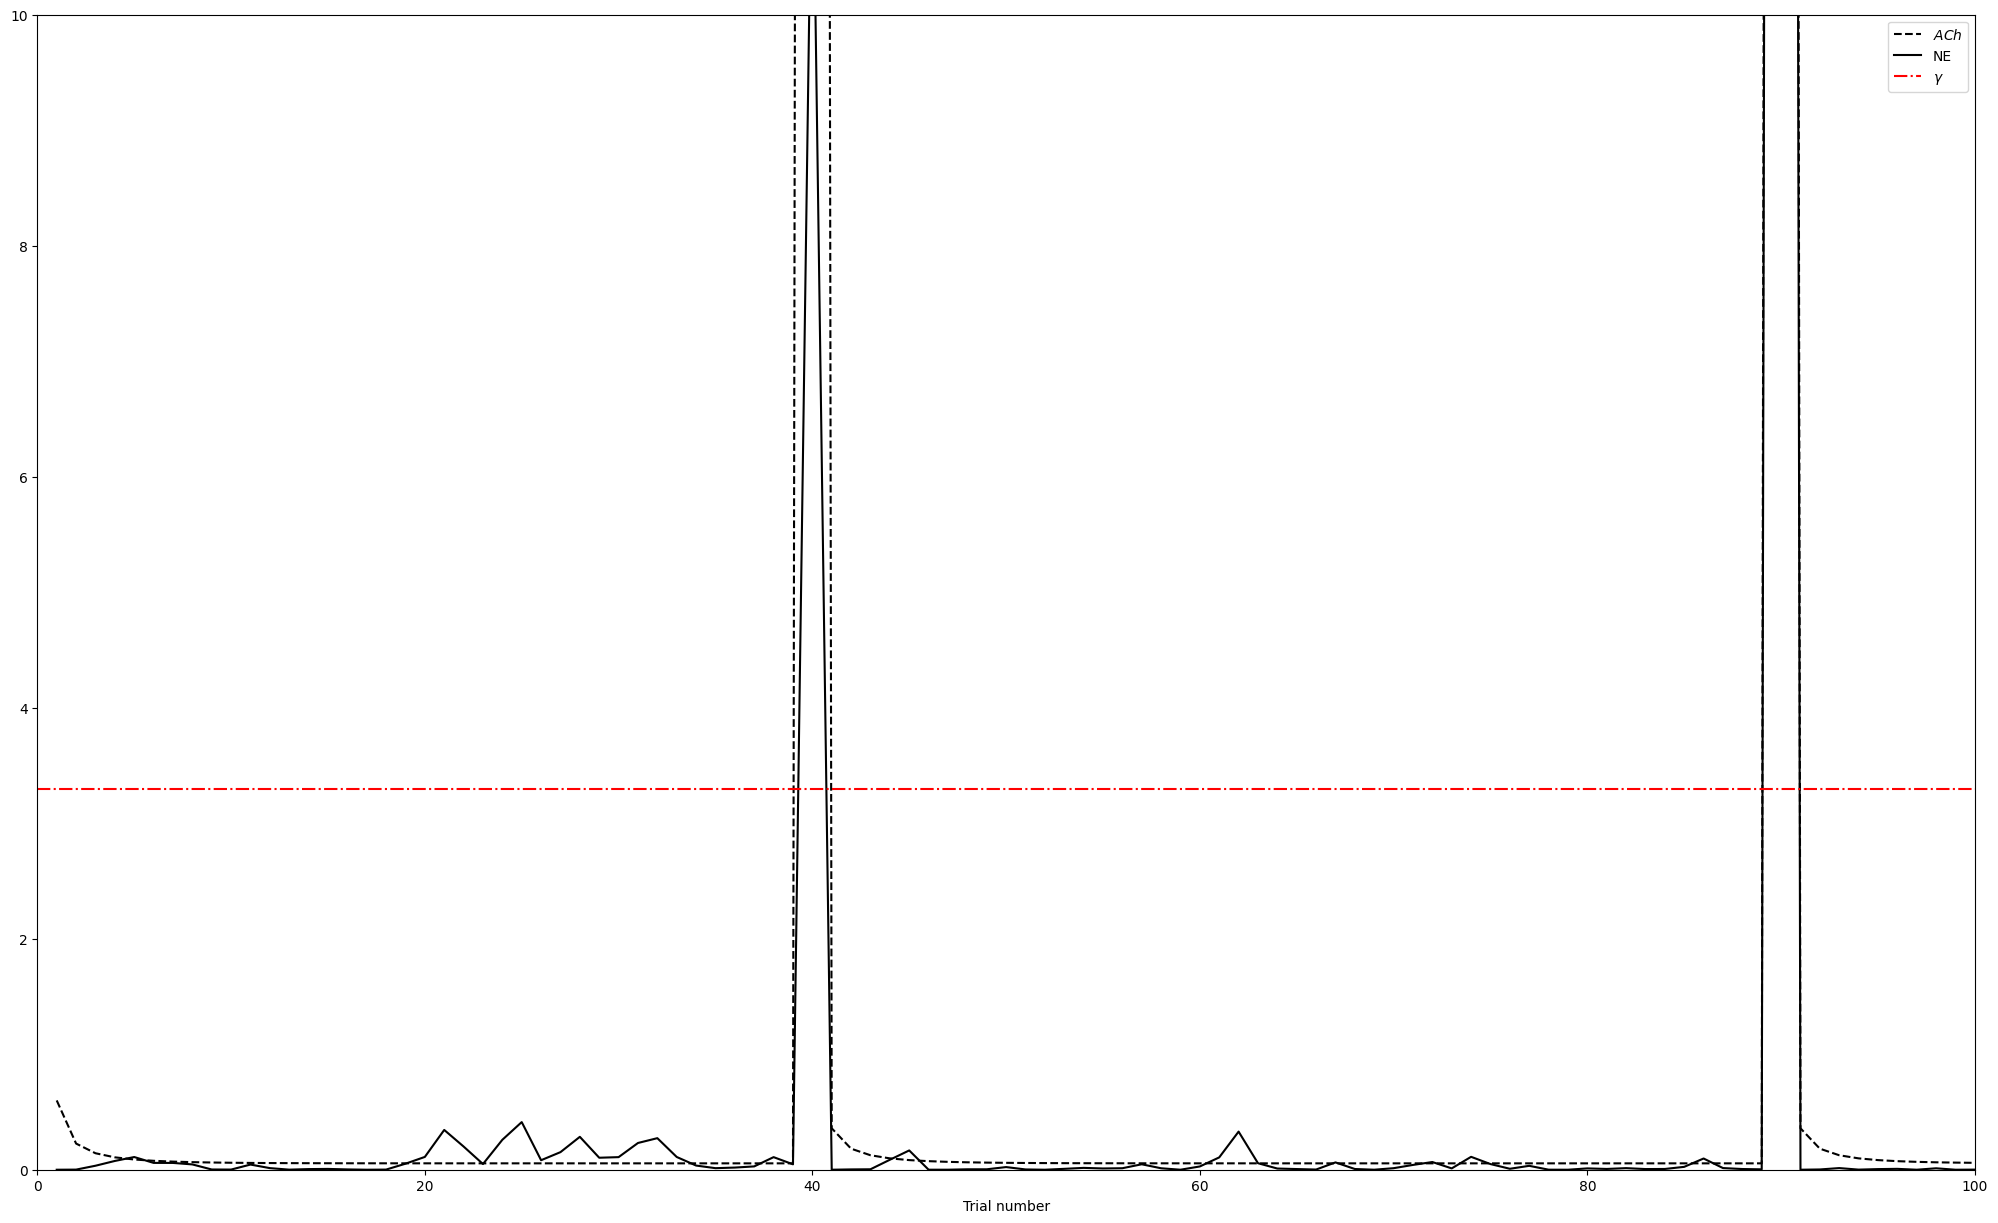

In [23]:
# %% Figure 3
numTrials = 100
u = np.ones((1, numTrials))
r = np.zeros((1, numTrials))
v = np.random.normal(0, 0.1, numTrials)
v_r = np.random.normal(0, 0.2, numTrials)
c = np.zeros((1, numTrials))
phi = np.zeros((1, numTrials))
c[0, 39] = 1
c[0, 89] = 1
phi[0, 39] = -2
phi[0, 89] = 6
weightReal = np.zeros((1, numTrials))
r[:, 0] = weightReal[:, 0] + v_r[0] + c[:, 0] * phi[:, 0]
for tr in range(1, numTrials):
    weightReal[:, tr] = weightReal[:, tr-1] + v[tr-1] + c[:, tr-1] * phi[:, tr-1]
    r[:, tr] = weightReal[:, tr] + v[tr] + c[:, tr] * phi[:, tr]

# Kalman
w0 = [0]
taw = 0.6
cov = 0.6
noiseP = 0.01
noisePhi = 100
gamma = 3.3

[weight, covariance, B] = InhancedKalmanFilter(u, r, cov, w0, taw, gamma, noiseP, noisePhi, numTrials)

plt.figure(figsize=(25, 15))
for i in range(len(r[0])):
    plt.scatter(range(1, numTrials+1), r, marker='x', c='k')
    plt.scatter(range(1, numTrials+1), weightReal, marker='.', c='r', linewidths=0.005)
plt.legend([r'$r(t)$', r'$w(t)$'])
plt.scatter(0, 0, 400, facecolors='none', edgecolors='k')
plt.scatter(40, -2, 400, facecolors='none', edgecolors='k')
plt.scatter(90, 4, 400, facecolors='none', edgecolors='k')
plt.xlim([1, 100])
plt.title('mean')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')

plt.figure(figsize=(25, 15))
for i in range(len(r[0])):
    plt.scatter(range(1, numTrials+1), weight, marker='o', facecolors='none', edgecolors='b')
    plt.scatter(range(1, numTrials+1), r, marker='x', c='k', linewidths=0.005)
    plt.scatter(range(1, numTrials+1), weightReal, marker='.', c='r', linewidths=0.005)
plt.legend([r'$\hat{w}(t)$'])
plt.xlim([1, 100])
plt.title('mean')
plt.xlabel("Trial number")
plt.ylabel(r'$\omega$')

plt.figure(figsize=(25, 15))
plt.plot(range(1, numTrials + 1), np.squeeze(covariance[0, 0, :]), '--k', label = r'$ACh$')
plt.plot(range(1, numTrials + 1), B[0], 'k', label='NE')
plt.axhline(y=gamma, linestyle='-.', color='r', label=r'$\gamma$')
plt.xlabel("Trial number")
plt.ylim([0, 10])
plt.xlim([0, 100])
plt.legend()
plt.show()

#### MSE

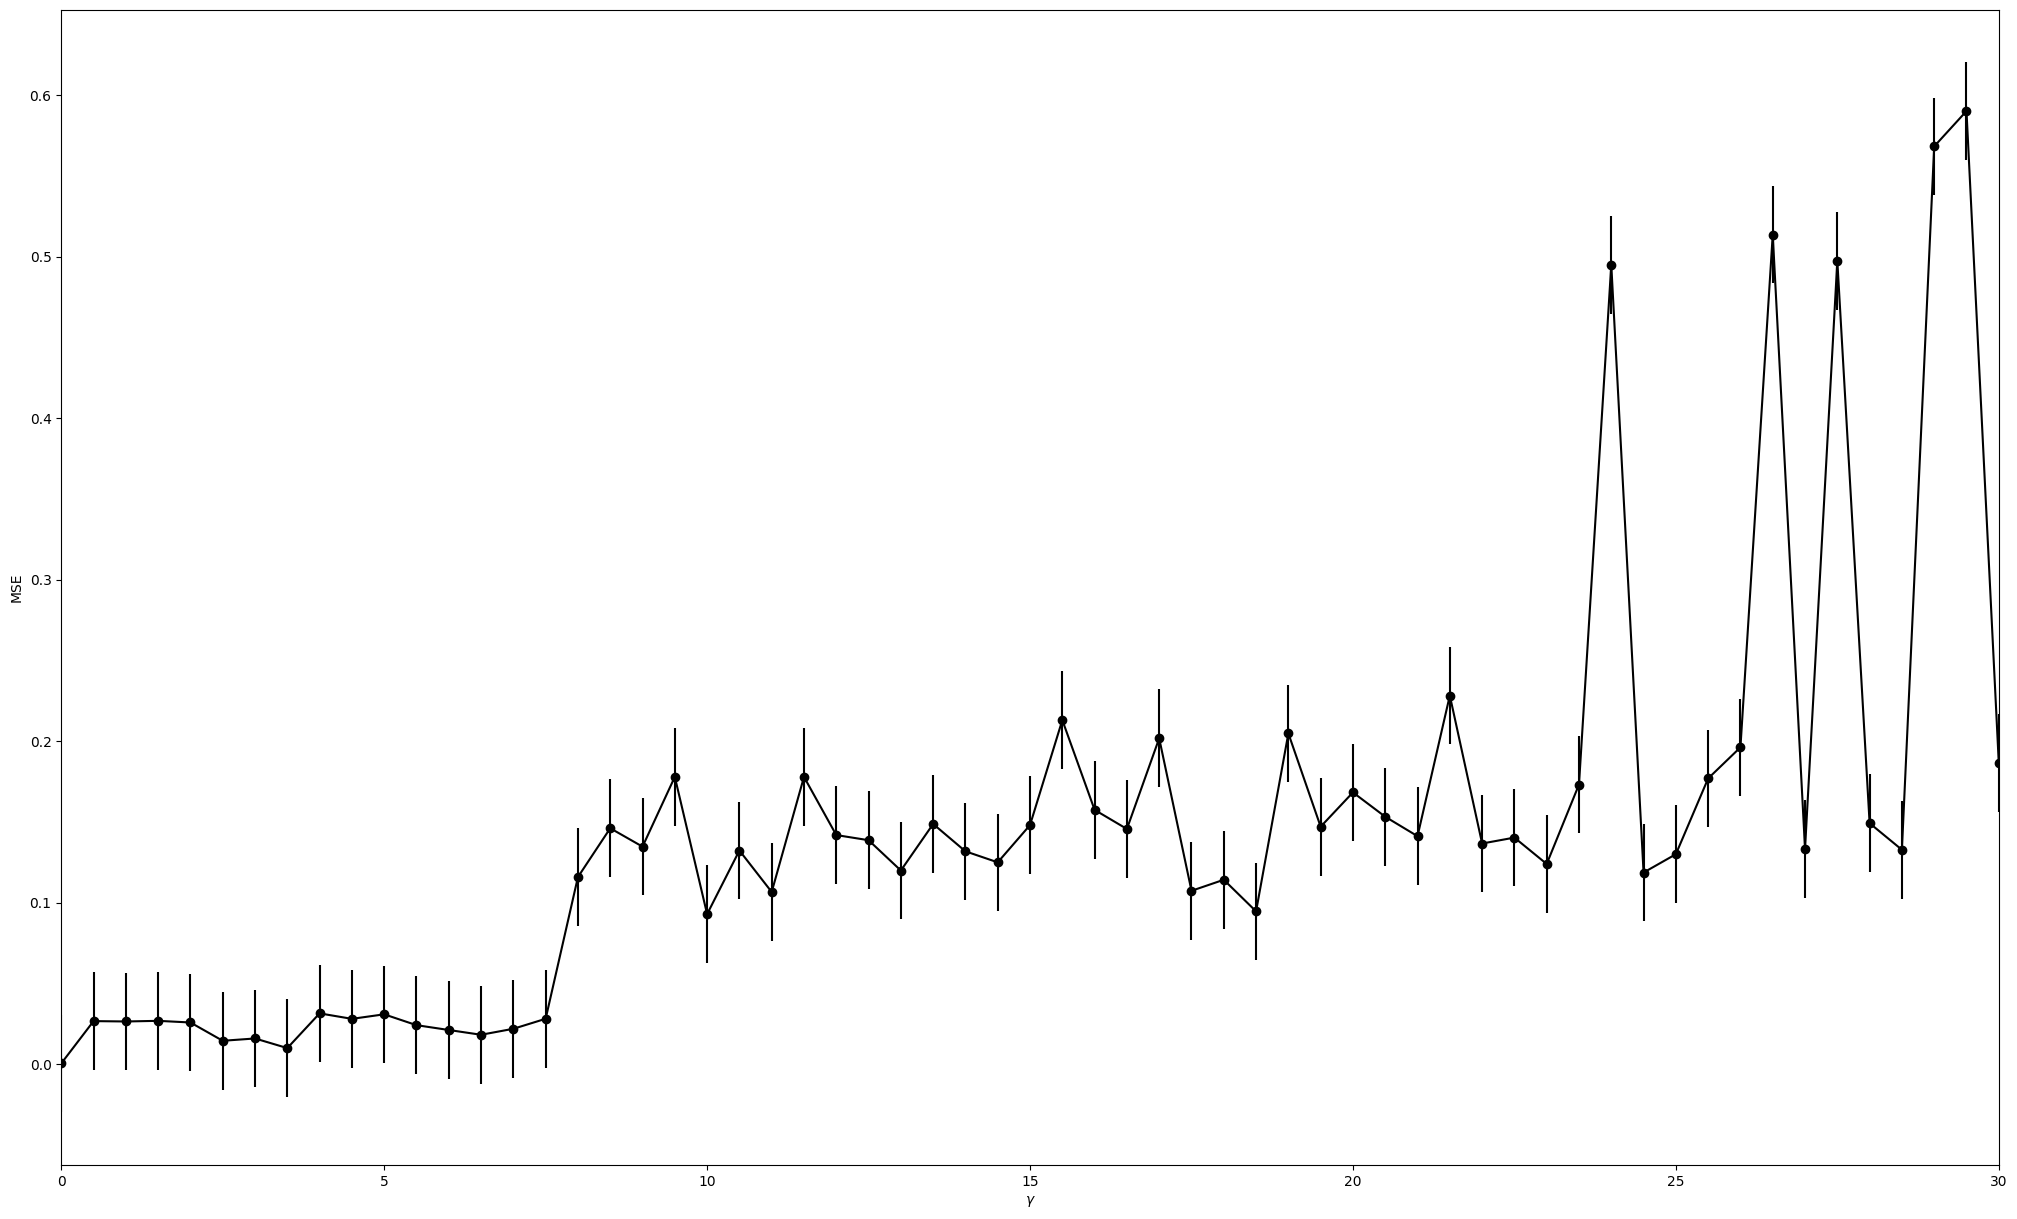

In [24]:
# %% MSE
numTrials = 100
gammas = np.arange(0, 30.5, 0.5)
MSEs = np.zeros((1, len(gammas)))

u = np.ones((1, numTrials))

w0 = [0]
taw = 0.7
cov = 0.6
noiseP = 0.01
noisePhi = 100

for gamma in range(len(gammas)):
    v = np.random.normal(0, 0.1, numTrials)
    v_r = np.random.normal(0, 0.5, numTrials)
    c = np.zeros((1, numTrials))
    phi = np.zeros((1, numTrials))
    c[0, 39] = 1
    c[0, 89] = 1
    phi[0, 39] = -2
    phi[0, 89] = 4
    
    weightReal = np.zeros((1, numTrials))
    r = np.zeros((1, numTrials))
    r[:, 0] = weightReal[:, 0] + v_r[0] + c[:, 0] * phi[:, 0]
    for tr in range(1, numTrials):
        weightReal[:, tr] = weightReal[:, tr-1] + v[tr-1] + c[:, tr-1] * phi[:, tr-1]
        r[:, tr] = weightReal[:, tr] + v[tr] + c[:, tr] * phi[:, tr]
    
    [weight, covariance, B] = InhancedKalmanFilter(u, r, cov, w0, taw, gammas[gamma], noiseP, noisePhi, numTrials)
    MSEs[0, gamma] = np.square(np.subtract(weight, weightReal)).mean()
    
plt.figure(figsize=(25, 15))
plt.plot(gammas, MSEs[0], 'k')
plt.errorbar(gammas, MSEs[0], yerr=np.square(np.subtract(weight, weightReal)).var()/10, fmt='ok')
plt.xlabel(r'$\gamma$')
plt.ylabel('MSE')
plt.xlim([0, 30])
plt.show()